# Analysis of MD2NMR

Here we investigate effect of max-match and num-matches and evaluate the accuracy with respect to observed values.

In [1]:
import sys, os, re, glob, multiprocessing, argparse
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
sys.path.append("/home/dkoes/git/MD2NMR/")
import shiftres,shifts
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Load observed values

In [2]:
observed = dict()
Ns = []
Hs = []
Cs = []
for fname in glob.glob('analysis/*.obs.csv'):
    (prot,_,_) = os.path.basename(fname).split('.')
    observed[prot] = dict()
    for line in open(fname):
        (rname,rid,N,H,C) = line.split(',')
        observed[prot][int(rid)] = tuple(map(float,(N,H,C)))
        Ns.append(float(N))
        Cs.append(float(C))
        Hs.append(float(H))

for x in [Ns,Hs,Cs]:
    print np.mean(x),np.max(x)-np.min(x)


118.703924399 33.1
8.28332474227 7.46
56.6788092784 24.46


In [3]:
prots = [f.split('/')[-1]  for f in glob.glob('analysis/benchmark/*') ]
prots

['1enh', '1ubq', '1qzm', '1igd', '2a3d', '3obl', '1hik', '1l2y']

In [4]:
ffs = [f.split('/')[-1] for f in glob.glob('analysis/benchmark/1enh/*')]

In [5]:
def calc_error(obs,calc):
    '''Compute RMSD between two dictionaries mapping resid -> CHN'''
    Ndiff = np.array([ obs[v][0]-calc[v][0] for v in sorted(obs.keys())])
    Hdiff = np.array([ obs[v][1]-calc[v][1] for v in sorted(obs.keys())])
    Cdiff = np.array([ obs[v][2]-calc[v][2] for v in sorted(obs.keys())])
    Nerr = np.sqrt(np.mean(np.square(Ndiff)))
    Herr = np.sqrt(np.mean(np.square(Hdiff)))
    Cerr = np.sqrt(np.mean(np.square(Cdiff)))
    return (Nerr,Herr,Cerr)

In [6]:
def load_shifts(fname):
    ret = dict()
    for line in open(fname):
        if not line.startswith('#'):
            (rid, rname, N,H,C,_,_,_,_) = line.split()
            ret[int(rid)] = tuple(map(float,(N,H,C)))
    return ret

Have precalculated shifts for all trajectories.  Load these in, average, and compute error for every protein/forcefield.

In [7]:
errors = dict()
errors['default'] = dict() #selct top
errors['0.2_1'] = dict() #select top within 0.2
errors['0.2_5'] = dict() #select top 5 within 0.2
errors['5'] = dict() #select top 5
errors['10'] = dict() #select top 5


for ff in ffs:
    for k in errors.keys():
        errors[k][ff] = dict()
    for prot in prots:
        if prot in observed: #skip 1l2y since it only has H
            for k in errors.keys():
                errors[k][ff][prot] = []
            for fname in glob.glob('analysis/benchmark/%s/%s/*.shifts'%(prot,ff)):
                shifts = load_shifts(fname)
                if fname.endswith('_0.2_1.shifts'):
                    err = errors['0.2_1']
                elif fname.endswith('_0.2_5.shifts'):
                    err = errors['0.2_5']
                elif fname.endswith('__5.shifts'):
                    err = errors['5']
                elif fname.endswith('__10.shifts'):
                    err = errors['10']                    
                else:
                    err = errors['default']
                err[ff][prot].append(calc_error(observed[prot],shifts))

In [8]:
aveerrors = dict()
for k in errors.keys():
    aveerrors[k] = dict()
    for ff in errors[k]:
        aveerrors[k][ff] = dict()
        for prot in errors[k][ff]:
            aveerrors[k][ff][prot] = np.mean(errors[k][ff][prot],axis=0)

In [9]:
#ave across proteins
protave = dict()
for k in aveerrors.keys():
    protave[k] = dict()
    for ff in aveerrors[k]:
        protave[k][ff] = np.mean(aveerrors[k][ff].values(),axis=0)

In [10]:
#ave across forcefields
totave = dict()
for k in protave.keys():
    totave[k] = np.mean(protave[k].values(),axis=0)

In [11]:
totave

{'0.2_1': array([ 6.3217602 ,  1.67312227,  2.05373688]),
 '0.2_5': array([ 6.2938293 ,  1.6761663 ,  2.02683641]),
 '10': array([ 6.1141772 ,  1.65618606,  1.97446706]),
 '5': array([ 6.07773366,  1.65413722,  1.99033592]),
 'default': array([ 6.17026861,  1.65281508,  2.04362298])}

**Conclusion**: Taking the five best matches does slightly better than only the top match, but imposing a cutoff does not help.

In [12]:
Nerr = []
Herr = []
Cerr = []
labels = []
fforder=['ff94','ff96','ff03','ff99SB','ff99SBildn','ff99SBnmr','ff14SB','ff14ipq','ff15ipq']
for ff in fforder:
    labels.append(ff)
    Nerr.append(np.vstack(aveerrors['default'][ff].values())[:,0])
    Herr.append(np.vstack(aveerrors['default'][ff].values())[:,1])
    Cerr.append(np.vstack(aveerrors['default'][ff].values())[:,2])

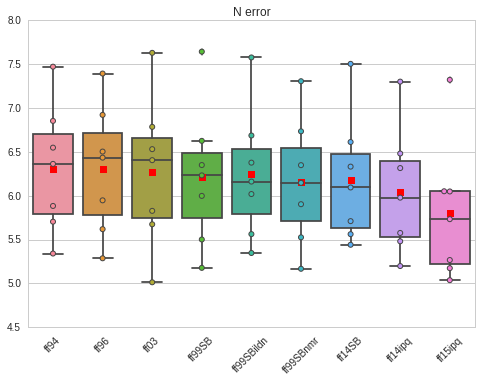

In [13]:
sns.set_style('whitegrid')

sns.boxplot(data=Nerr,showmeans=True)
sns.swarmplot(data=Nerr,linewidth=1)
plt.xticks(xrange(len(labels)),labels,rotation=45);
plt.title('N error');

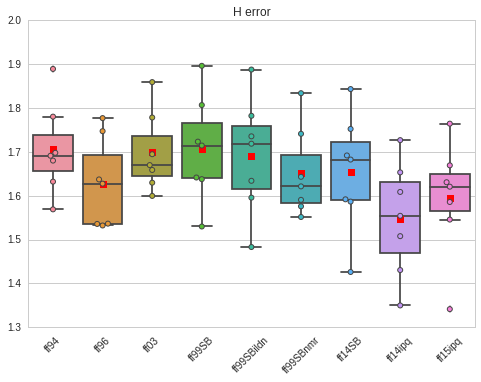

In [14]:
sns.boxplot(data=Herr,showmeans=True)
sns.swarmplot(data=Herr,linewidth=1)
plt.xticks(xrange(len(labels)),labels,rotation=45);
plt.title('H error');

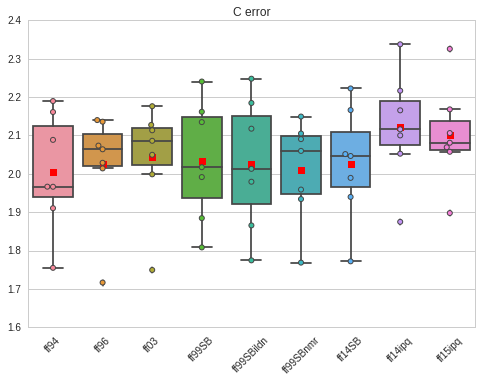

In [15]:
sns.boxplot(data=Cerr,showmeans=True)
sns.swarmplot(data=Cerr,linewidth=1)
plt.xticks(xrange(len(labels)),labels,rotation=45);
plt.title('C error');

In [16]:
data = pd.DataFrame(columns=['ff','prot','N','H','C'])
for ff in errors['default'].iterkeys():
    for prot in errors['default'][ff].iterkeys():
        for (N,H,C) in errors['default'][ff][prot]:
            data.loc[len(data)] = [ff,prot,N,H,C]

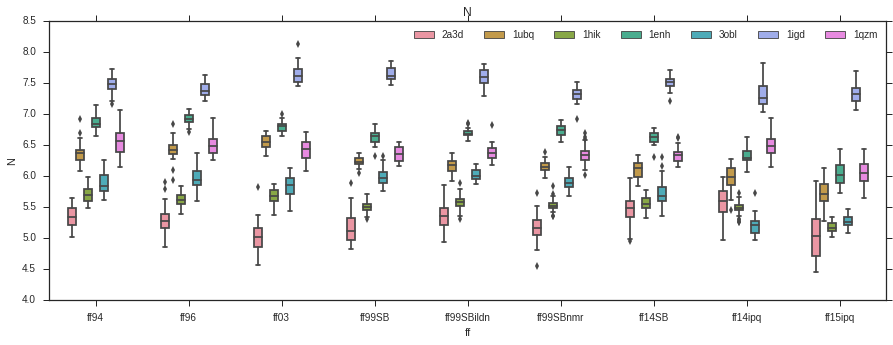

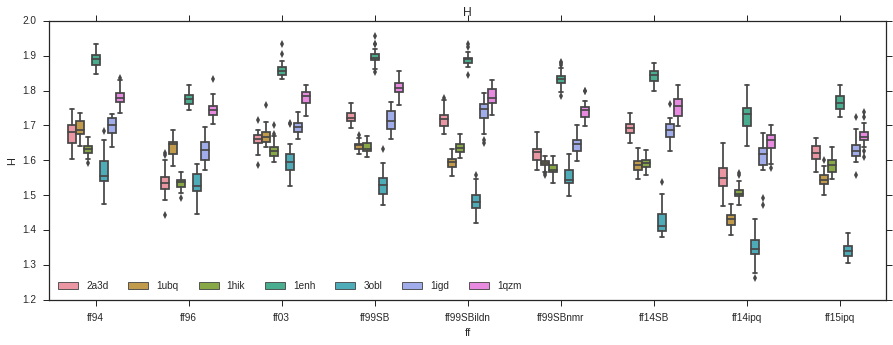

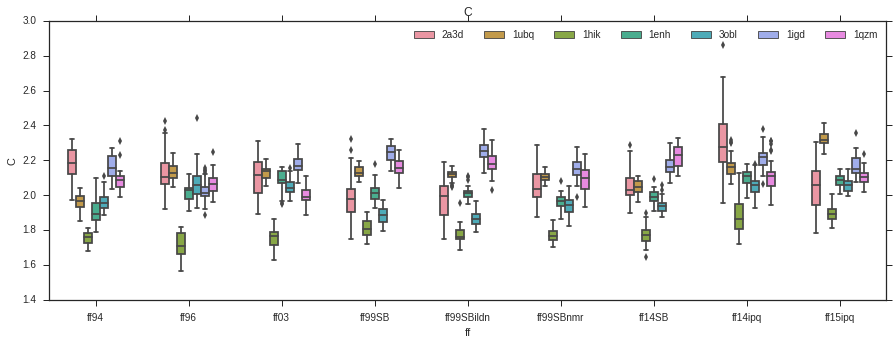

In [17]:
for S in ['N','H','C']:
    plt.figure(figsize=(15,5))
    sns.set(style="ticks")
    sns.boxplot(x='ff',y=S,hue='prot',data=data,width=.6,order=fforder)
    plt.legend(loc='best',ncol=7)
    plt.title(S)
    plt.show()

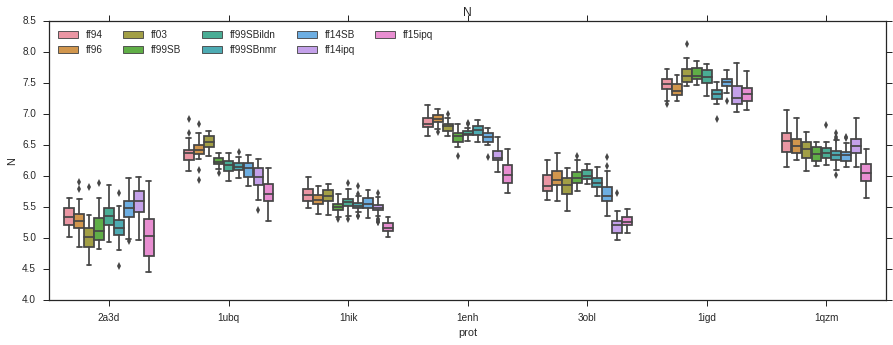

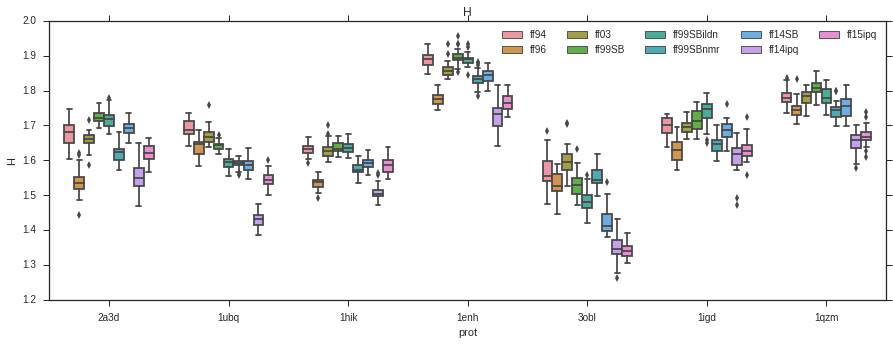

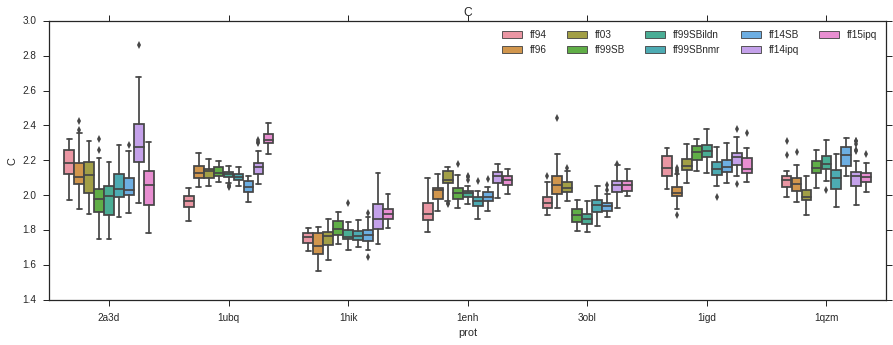

In [18]:
for S in ['N','H','C']:
    plt.figure(figsize=(15,5))
    sns.set(style="ticks")
    sns.boxplot(x='prot',y=S,hue='ff',data=data,width=.75,hue_order=fforder)
    plt.legend(loc='best',ncol=5)
    plt.title(S)
    plt.show()

In [19]:
data.columns

Index([u'ff', u'prot', u'N', u'H', u'C'], dtype='object')

In [20]:
ff94 = data.loc[data['ff'] == 'ff94'].groupby(['prot']).mean()

In [53]:
Nfactor = np.std(Ns) #(np.max(Ns)-np.min(Ns))
Cfactor = np.std(Cs) #(np.max(Cs)-np.min(Cs))
Hfactor = np.std(Hs) # (np.max(Hs)-np.min(Hs))


data['Nnorm'] = data.N.subtract(ff94.loc[data.prot].N.values)/Nfactor
data['Cnorm'] = data.C.subtract(ff94.loc[data.prot].C.values)/Cfactor
data['Hnorm'] = data.H.subtract(ff94.loc[data.prot].H.values)/Hfactor

In [54]:
normdata = data.groupby(['ff','prot']).mean().reset_index()
normdata['ff'] = pd.Categorical(normdata['ff'],categories=fforder)
normdata=normdata.sort_values(by='ff');

In [55]:
from matplotlib.ticker import FormatStrFormatter


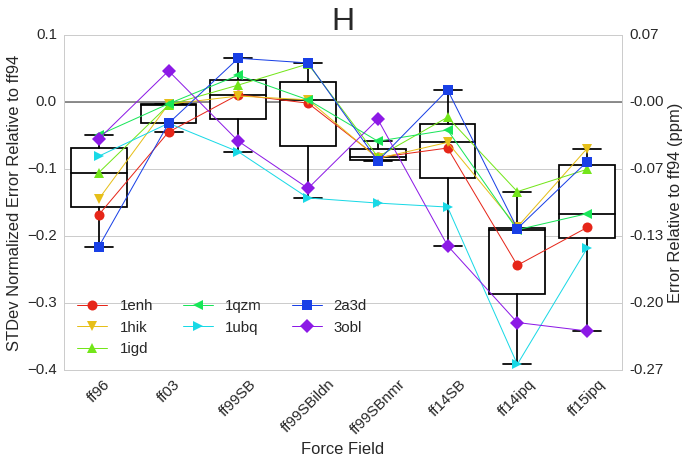

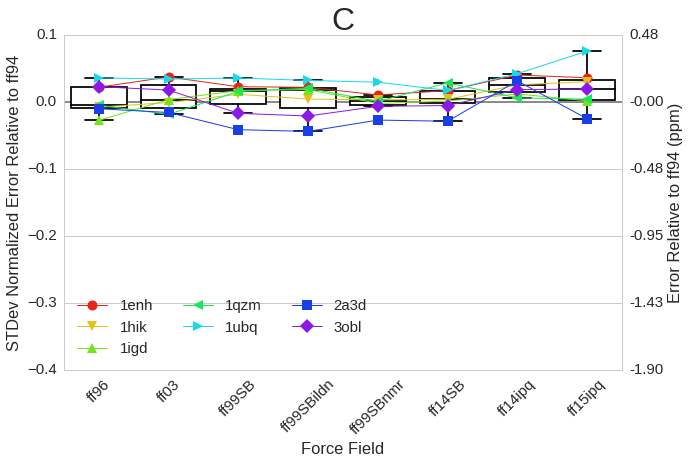

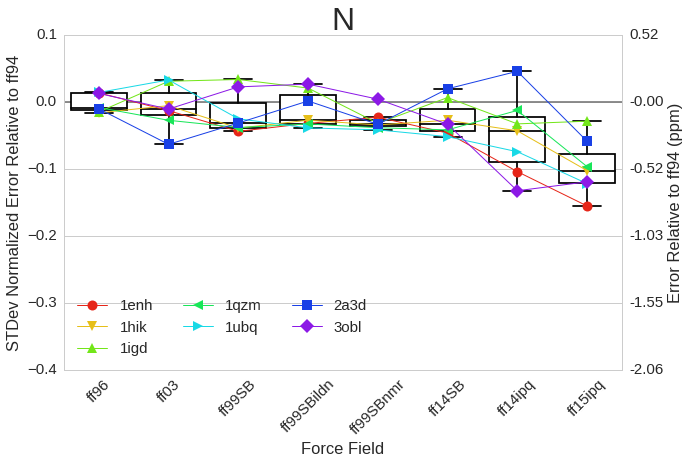

In [197]:
def summary_plot(name):
    plt.figure(figsize=(10,6))
    sns.set(font_scale=1.5)
    sns.set_style('whitegrid')
    sns.set_palette(sns.hls_palette(8, l=.5, s=.8))
    ax = sns.boxplot(data=normdata,x='ff',y=name,order=fforder[1:],color='white')
    for box in ax.artists:
        box.set_edgecolor('k')
        box.set_zorder(2)
    for line in ax.lines:
        line.set_color('k')
        line.set_zorder(3)
    plt.axhline(y=0, color='gray',zorder=1)

    #sns.swarmplot(data=normdata,x='ff',y='Hnorm',linewidth=1,order=fforder[1:])
    prots = normdata.prot.unique()
    markers=['o','v','^','<','>','s','D','*','|','X']
    for (i,p) in enumerate(sorted(prots)):
        pdata = normdata[normdata['prot']==p][name]
        plt.plot(xrange(len(pdata)-1),pdata[1:],'-'+markers[i],label=p,markersize=10,linewidth=1,zorder=5)
    plt.legend(loc='best',ncol=3)
    plt.ylabel("STDev Normalized Error Relative to ff94")
    plt.xlabel("Force Field")
    plt.xticks(rotation=45)
    plt.ylim(-.4,.1)
    tics = np.arange(-.4,.101,0.1)
    ax.yaxis.set_ticks(tics)
    ax2 = ax.twinx()
    if name[0] == 'H':
        factor = Hfactor
    elif name[0] == 'C':
        factor = Cfactor
    elif name[0] == 'N':
        factor = Nfactor
    ax2.set_ylim(tics[0]*factor,tics[-1]*factor)
    ax2.yaxis.set_ticks(tics*factor)
    ax2.yaxis.grid(False)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.ylabel('Error Relative to ff94 (ppm)')
    plt.title(name[0],fontsize=32)
    plt.savefig(name+'.pdf',bbox_inches='tight')
    
    
summary_plot('Hnorm')
summary_plot('Cnorm')
summary_plot('Nnorm')

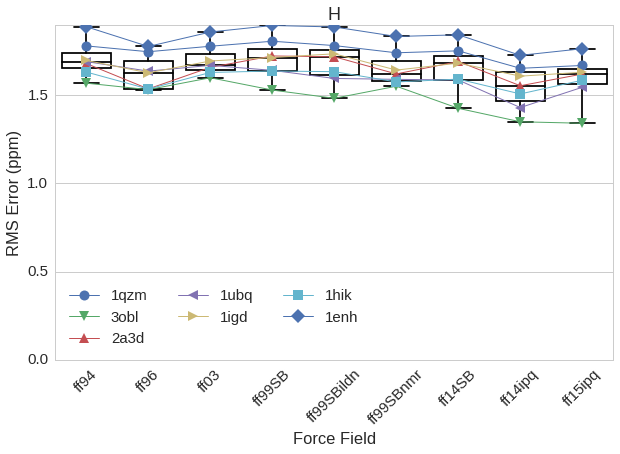

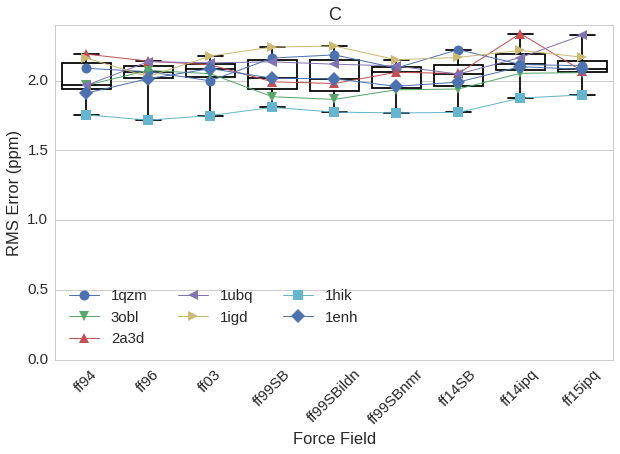

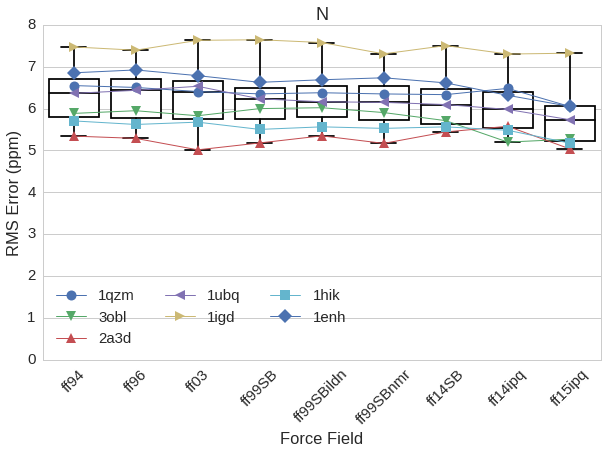

In [61]:
def summary_plot2(name):
    plt.figure(figsize=(10,6))
    sns.set(font_scale=1.5)
    sns.set_style('whitegrid')
    ax = sns.boxplot(data=normdata,x='ff',y=name,order=fforder,color='white',whis='range')
    for box in ax.artists:
        box.set_edgecolor('k')
        box.set_zorder(2)
    for line in ax.lines:
        line.set_color('k')
        line.set_zorder(3)
    #plt.axhline(y=0, color='gray',zorder=1)

    #sns.swarmplot(data=normdata,x='ff',y='Hnorm',linewidth=1,order=fforder[1:])
    prots = normdata.prot.unique()
    markers=['o','v','^','<','>','s','D','*','|','X']
    
    for (i,p) in enumerate(prots):
        pdata = normdata[normdata['prot']==p][name]
        plt.plot(xrange(len(pdata)),pdata,'-'+markers[i],label=p,markersize=10,linewidth=1,zorder=5)
    plt.legend(loc='best',ncol=3)
    plt.xlabel("Force Field")
    plt.ylim(0)
    plt.ylabel("RMS Error (ppm)")
    plt.xticks(rotation=45)

    plt.title(name[0])
    plt.savefig(name+'_rms.pdf')
    
    
summary_plot2('H')
summary_plot2('C')
summary_plot2('N')


In [62]:
normdata[normdata['prot']=='1enh'].Hnorm

28   -7.687453e-16
35   -1.686538e-01
0    -4.517228e-02
42    1.065982e-02
49   -2.107568e-03
56   -8.323205e-02
7    -6.907653e-02
14   -2.442353e-01
21   -1.877511e-01
Name: Hnorm, dtype: float64

In [305]:
# read in patterns
helix = set('H')
sheet = set('E')
import collections
ssdict = collections.defaultdict(dict)
patterns = dict() #indexed by protein than rid
for fname in glob.glob('analysis/patterns/*.pat'):
    prot = os.path.basename(fname)[:4]
    patterns[prot] = dict()
    for line in open(fname):
        (ss, pat, perc, rname, rid) = line.split()
        rid = int(rid)
        ssdict[prot][rid] = ss
        if 'O' in pat and 'C' in pat:
            if ss == 'H':
                patterns[prot][rid] = 'O_Helix'
            elif ss == 'E':
                patterns[prot][rid] = 'O_Sheet'
            elif ss == 'C' or ss == 'T':
                patterns[prot][rid] = 'O_Coil'
            else:
                patterns[prot][rid] = 'O_UNK'
        elif 'A' in pat:
            patterns[prot][rid] = 'Acid'
        elif 'L' in pat:
            patterns[prot][rid] = "OH"
        elif 'W' in pat:
            patterns[prot][rid] = 'Water'
        elif 'R' in pat:
            patterns[prot][rid] = "Ring"
        else:
            patterns[prot][rid] = 'UNK'
        

In [177]:
#compute overall average
import collections
overall = dict()
allvals = dict()
allN = collections.defaultdict(list)
allC = collections.defaultdict(list)
allH = collections.defaultdict(list)
for ff in ffs:
    overall[ff] = dict()
    allvals[ff] = dict()
    for prot in prots:
        if prot in observed: #skip 1l2y since it only has H
            resvals = dict()
            allvals[ff][prot] = list()
            for fname in glob.glob('analysis/benchmark/%s/%s/*.shifts'%(prot,ff)):
                shifts = load_shifts(fname)
                if fname.endswith('_0.2_1.shifts'):
                    pass
                elif fname.endswith('_0.2_5.shifts'):
                    pass
                elif fname.endswith('__5.shifts'):
                    pass
                elif fname.endswith('__10.shifts'):
                    pass                    
                else:
                    for r in shifts:
                        if r not in resvals:
                            resvals[r] = []
                        resvals[r].append(shifts[r])
            diffs = []
            for r in resvals:
                if r in observed[prot]:
                    resvals[r] = np.mean(resvals[r],axis=0)
                    diff = observed[prot][r]-resvals[r]
                    allvals[ff][prot].append([(resvals[r][i],observed[prot][r][i]) for i in xrange(3)]+[(r,r)]) #total laziness
                    allN[ff].append((resvals[r][0],observed[prot][r][0]))
                    allH[ff].append((resvals[r][1],observed[prot][r][1]))
                    allC[ff].append((resvals[r][2],observed[prot][r][2]))

                    diffs.append(diff)
            overall[ff][prot] = np.sqrt(np.sum(np.square(diffs),axis=0)/len(diffs))
            
    allN[ff] = np.array(allN[ff])
    allH[ff] = np.array(allH[ff])
    allC[ff] = np.array(allC[ff])

    

In [178]:
overall['ff03']

{'1enh': array([ 6.74419706,  1.85376221,  2.05624168]),
 '1hik': array([ 5.52690379,  1.61824516,  1.65345739]),
 '1igd': array([ 7.57795442,  1.69026609,  2.13969935]),
 '1qzm': array([ 6.29883774,  1.77031176,  1.93623983]),
 '1ubq': array([ 6.45866895,  1.66003602,  2.10276881]),
 '2a3d': array([ 4.74194956,  1.63983802,  1.98036943]),
 '3obl': array([ 5.61321198,  1.5831948 ,  1.94143696])}

In [179]:
import scipy.stats

(0.92092007857258584, 1.6314947466044742e-239)

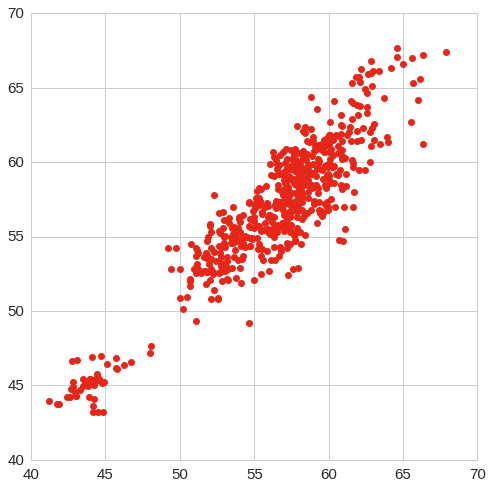

In [180]:
a = allC['ff14ipq']
plt.figure(figsize=(8,8))

plt.plot(a[:,0],a[:,1],'o')
np.corrcoef(a[:,0],a[:,1])
scipy.stats.pearsonr(a[:,0],a[:,1])

In [181]:
corrs = pd.DataFrame(columns=['ff','prot','N','H','C'])
allv = pd.DataFrame(columns=['ff','prot','rid','pattern','N','H','C','No','Ho','Co'])
for ff in allvals.keys():
    for prot in allvals[ff].keys():
        nhc = np.array(allvals[ff][prot])
        for r in nhc:
            rid = int(r[3][0])
            allv.loc[len(allv)] = (ff,prot,rid,patterns[prot][rid],r[0][0],r[1][0],r[2][0],r[0][1],r[1][1],r[2][1])
        cs = [scipy.stats.pearsonr(nhc[:,i,0],nhc[:,i,1])[0] for i in xrange(3)]
        corrs.loc[len(corrs)] = (ff,prot,cs[0],cs[1],cs[2])

In [182]:
allcorrs = pd.DataFrame(columns=['ff','elem','R'])
for ff in ffs:
    Nr = scipy.stats.pearsonr(allv[allv.ff==ff].N,allv[allv.ff==ff].No)[0]
    Hr = scipy.stats.pearsonr(allv[allv.ff==ff].H,allv[allv.ff==ff].Ho)[0]
    Cr = scipy.stats.pearsonr(allv[allv.ff==ff].C,allv[allv.ff==ff].Co)[0]
    allcorrs.loc[len(allcorrs)] = (ff,'N',Nr)
    allcorrs.loc[len(allcorrs)] = (ff,'H',Hr)
    allcorrs.loc[len(allcorrs)] = (ff,'C',Cr)    

(0.5, 0.70000000000000007)

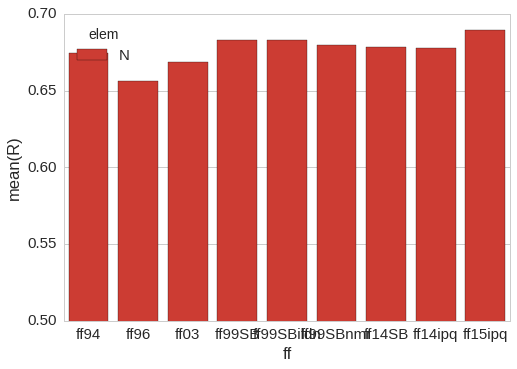

In [183]:
sns.barplot(data=allcorrs[allcorrs.elem == 'N'],x='ff',y='R',hue='elem',order=fforder)
plt.ylim(.5)

In [184]:
for r in allvals['ff15ipq']['3obl']:
    print r[3][0]+1,r[2][0]

4 54.8518484848
5 51.0066969697
6 60.8776666667
7 57.22
8 50.8474242424
9 52.9146969697
10 55.5599393939
11 44.8450606061
12 43.3176969697
13 59.3476363636
14 58.1694848485
15 50.0993939394
17 54.8051515152
18 52.7483939394
19 58.9274242424
20 44.6989393939
21 42.7753030303
22 54.1955454545
23 53.1742121212
24 56.5106060606
25 59.8371212121
26 43.1575757576
27 57.6988181818
28 53.9656666667
29 59.575030303
30 55.9461818182
31 55.0171212121
32 53.4739090909
33 61.5258181818
34 58.424
35 51.1296060606
36 60.6357878788
37 50.0594242424
38 54.8653030303
39 57.6726969697
40 56.0444848485
41 44.5743030303
42 51.7657272727
43 57.1400606061
44 44.9261515152
45 57.9947272727
46 61.3981515152
47 53.0216060606
48 50.9453939394
49 45.0004242424
50 57.6938484848
51 53.0334848485
52 59.1648787879
53 59.3653333333
54 49.0226060606
55 43.8153636364
56 60.0497878788
57 42.9662121212
59 57.752969697
60 42.6513636364
61 55.2223030303
62 53.5123333333
63 50.1803030303
64 58.6722121212
65 53.4085151515
66 

In [185]:
allv[allv.ff=='ff15ipq'].sort_values(by='prot')

ff  prot    rid  pattern           N         H          C       No  \
872  ff15ipq  1enh   30.0  O_Helix  117.385182  6.475182  57.295030  119.168   
867  ff15ipq  1enh   25.0    Water  111.418576  6.889606  58.404303  113.126   
866  ff15ipq  1enh   24.0    Water  121.343212  7.137242  51.943818  123.054   
865  ff15ipq  1enh   23.0      UNK  116.380303  6.781455  56.847636  115.608   
864  ff15ipq  1enh   22.0    Water  117.457424  6.124212  56.449242  122.594   
863  ff15ipq  1enh   21.0   O_Coil  104.426758  6.379545  54.328485  117.173   
862  ff15ipq  1enh   20.0  O_Helix  122.840030  6.213545  58.448212  119.042   
861  ff15ipq  1enh   19.0  O_Helix  114.632909  6.534364  55.794152  114.382   
860  ff15ipq  1enh   18.0  O_Helix  111.748939  6.722455  59.658000  121.715   
859  ff15ipq  1enh   17.0  O_Helix  120.041848  6.451242  60.116576  119.660   
858  ff15ipq  1enh   16.0  O_Helix  112.755242  6.176182  57.913152  119.470   
868  ff15ipq  1enh   26.0    Water  123.492030  7.235970  60.103939  122.414   
857  ff15ipq  1enh   15.0  O_Helix  107.008576  6.580848  57.081000  117.890   
855  ff15ipq  1enh   13.0  O_Helix  113.121030  6.050758  57.573091  118.428   
854  ff15ipq  1enh   12.0  O_Helix  117.804515  6.345939  52.483152  120.182   
853  ff15ipq  1enh   11.0  O_Helix  120.063545  7.205667  57.895970  118.026   
852  ff15ipq  1enh   10.0  O_Helix  111.995939  5.941152  55.956636  120.394   
851  ff15ipq  1enh    9.0     Acid  123.127788  8.506303  57.993606  122.296   
850  ff15ipq  1enh    8.0    Water  113.310939  6.526000  61.573636  117.192   
849  ff15ipq  1enh    7.0      UNK  111.939242  7.392636  56.651424  119.199   
848  ff15ipq  1enh    6.0    Water  117.743545  6.677606  55.881667  119.722   
847  ff15ipq  1enh    5.0    Water  122.184121  6.716242  51.594697  127.319   
846  ff15ipq  1enh    4.0      UNK  109.413515  6.556455  60.082152  116.133   
856  ff15ipq  1enh   14.0  O_Helix  118.800758  7.007455  58.680455  121.555   
869  ff15ipq  1enh   27.0    Water  106.982727  6.545848  57.426182  118.009   
845  ff15ipq  1enh    3.0    Water  115.629515  6.873758  53.867848  122.303   
871  ff15ipq  1enh   29.0  O_Helix  114.693606  6.909061  58.961576  120.240   
895  ff15ipq  1enh   53.0  O_Helix  109.677818  6.052879  53.941424  117.833   
894  ff15ipq  1enh   52.0  O_Helix  119.123970  6.270606  51.392242  120.123   
893  ff15ipq  1enh   51.0  O_Helix  114.635909  6.370727  57.140091  117.662   
..       ...   ...    ...      ...         ...       ...        ...      ...   
964  ff15ipq  3obl   73.0  O_Sheet  122.042212  8.450152  58.157485  124.977   
965  ff15ipq  3obl   74.0  O_Sheet  112.709818  8.591212  51.136303  116.368   
966  ff15ipq  3obl   75.0  O_Sheet  114.071212  6.151879  52.968061  120.971   
967  ff15ipq  3obl   76.0    Water  116.152121  6.939455  56.376515  125.688   
968  ff15ipq  3obl   77.0    Water  107.664485  6.750485  44.859636  108.089   
969  ff15ipq  3obl   78.0    Water  106.222152  6.614758  43.139970  110.024   
970  ff15ipq  3obl   79.0    Water  118.954152  7.101485  57.832697  116.108   
971  ff15ipq  3obl   80.0    Water  110.127000  6.390515  57.516970  112.894   
972  ff15ipq  3obl   81.0   O_Coil  124.449879  5.874091  49.928727  126.518   
973  ff15ipq  3obl   83.0    Water  116.399424  6.697848  54.284212  120.286   
974  ff15ipq  3obl   84.0  O_Sheet  120.667818  8.478909  55.321970  118.756   
975  ff15ipq  3obl   85.0    Water  109.106000  6.414576  57.887788  118.043   
976  ff15ipq  3obl   86.0  O_Sheet  117.537273  7.781818  44.368030  115.954   
962  ff15ipq  3obl   71.0  O_Sheet  121.932182  8.173848  54.591879  123.168   
977  ff15ipq  3obl   87.0    Water  102.450606  6.601303  42.752364  109.388   
979  ff15ipq  3obl   89.0  O_Sheet  121.855091  8.119606  52.776939  125.963   
980  ff15ipq  3obl   90.0  O_Sheet  116.134455  8.101970  59.495030  123.233   
981  ff15ipq  3obl   91.0   O_Coil  123.535091  7.802818  50.182970  123.726   
982  ff15i

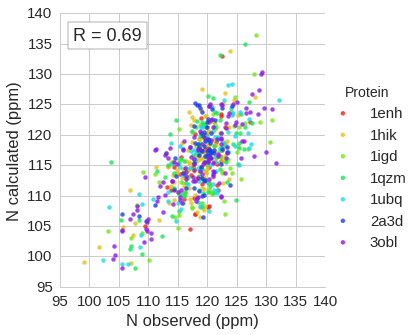

In [186]:
dat = allv[allv.ff=='ff15ipq'].sort_values(by='prot')

r = sns.lmplot('No', 'N', data=dat, hue='prot', fit_reg=False,order=sorted(prot))
plt.xlim(95,140)
r._legend.set_title("Protein")
r.set_xlabels("N observed (ppm)")
r.set_ylabels("N calculated (ppm)")
plt.savefig('Ncorr.pdf',bbox_inches='tight')
R = scipy.stats.pearsonr(dat.N,dat.No)[0]
plt.text(.05,.95,'R = %.2f'%R,horizontalalignment='left',
     verticalalignment='top',bbox={'facecolor':'white', 'pad':5},transform = plt.gca().transAxes)

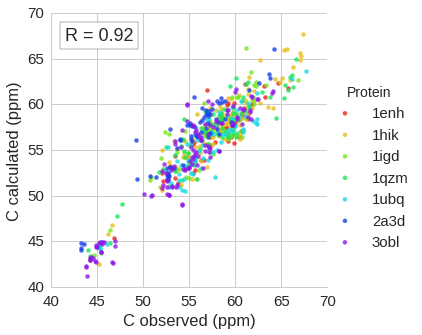

In [187]:
r = sns.lmplot('Co', 'C', data=dat, hue='prot', fit_reg=False)
plt.ylim(40,70)
r._legend.set_title("Protein")
r.set_xlabels("C observed (ppm)")
r.set_ylabels("C calculated (ppm)")
plt.savefig('Ccorr.pdf',bbox_inches='tight')
R = scipy.stats.pearsonr(dat.C,dat.Co)[0]
plt.text(0.05,.95,'R = %.2f'%R,horizontalalignment='left',
     verticalalignment='top',bbox={'facecolor':'white', 'pad':5},transform = plt.gca().transAxes)

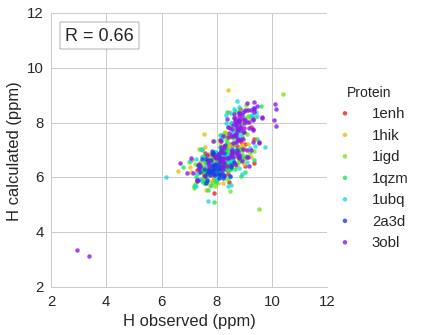

In [188]:
r = sns.lmplot('Ho', 'H', data=dat, hue='prot', fit_reg=False,scatter=True,aspect=1)
plt.xlim(2,12)
plt.ylim(2,12)
r._legend.set_title("Protein")
r.set_xlabels("H observed (ppm)")
r.set_ylabels("H calculated (ppm)")
plt.savefig('Hcorr.pdf',bbox_inches='tight')
R = scipy.stats.pearsonr(dat.H,dat.Ho)[0]
plt.text(0.05,.95,'R = %.2f'%R,horizontalalignment='left',
     verticalalignment='top',bbox={'facecolor':'white', 'pad':5},transform = plt.gca().transAxes)

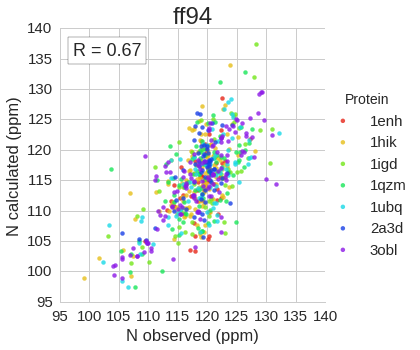

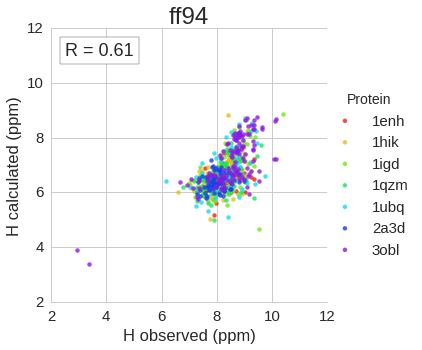

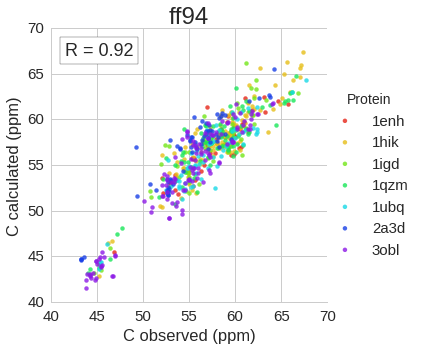

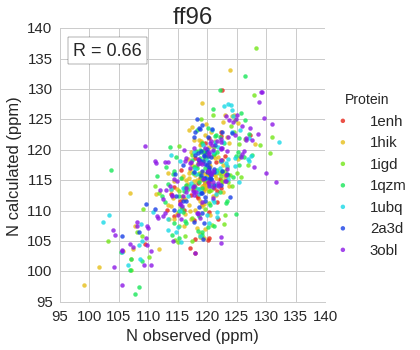

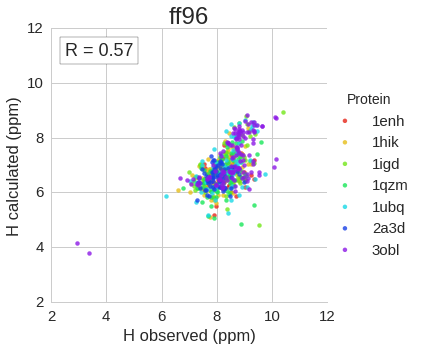

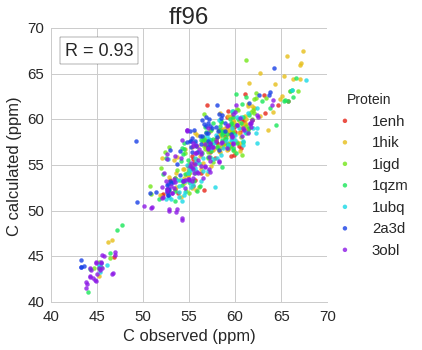

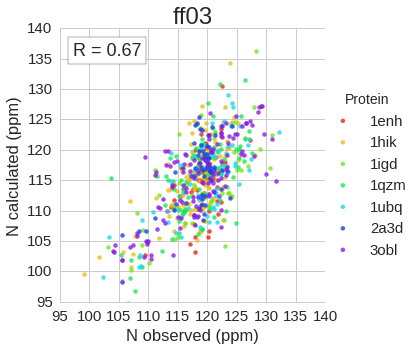

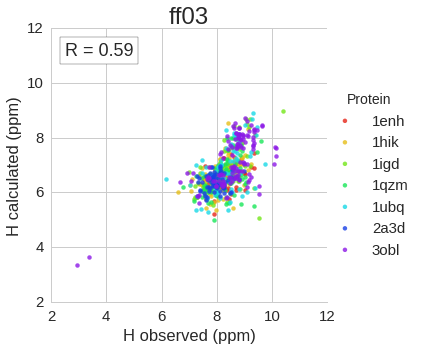

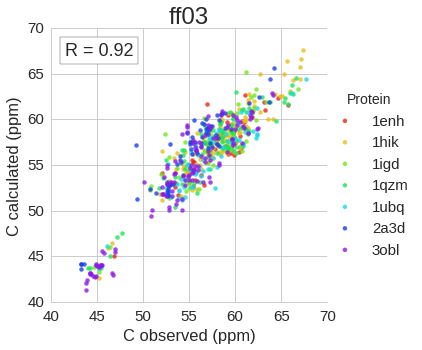

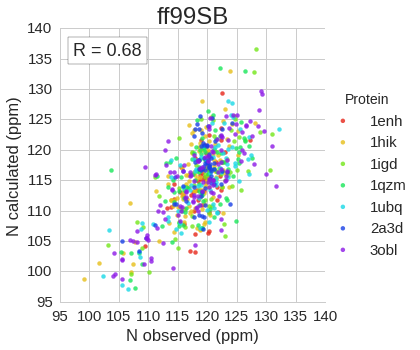

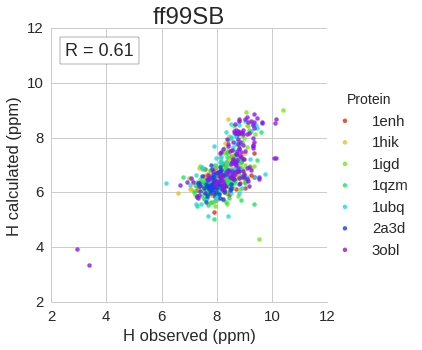

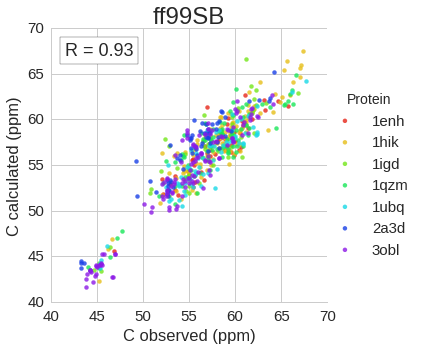

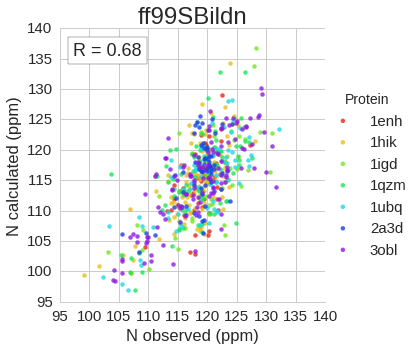

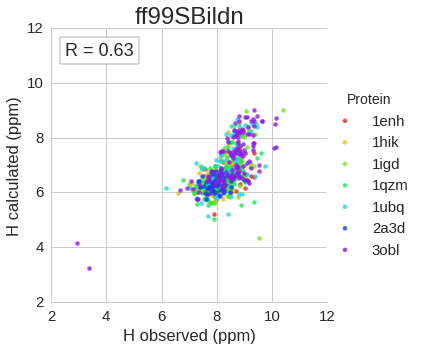

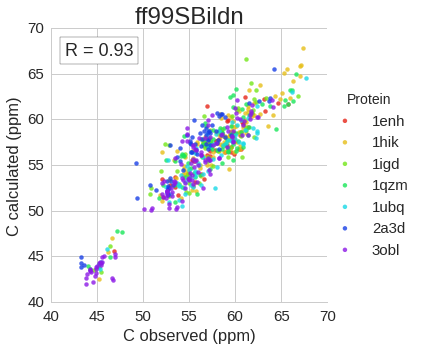

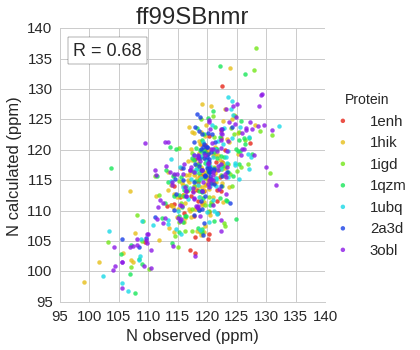

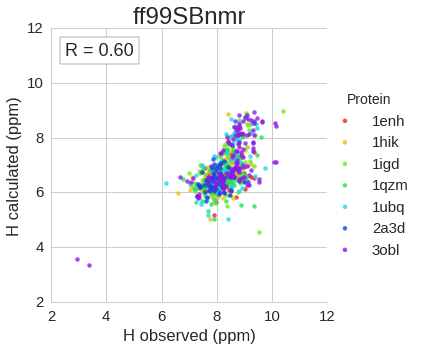

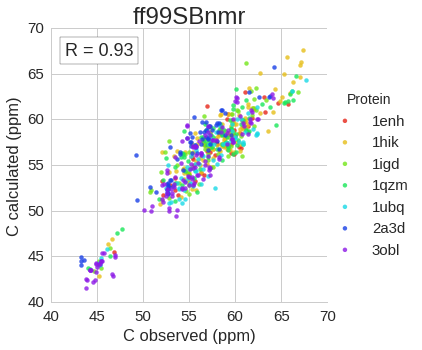

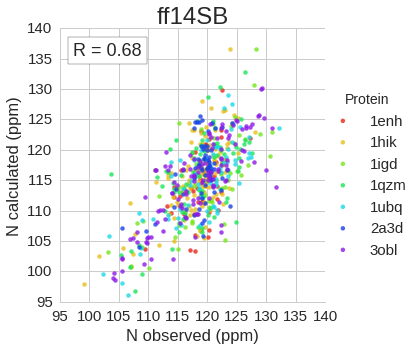

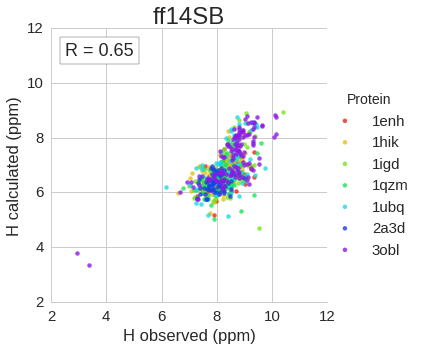

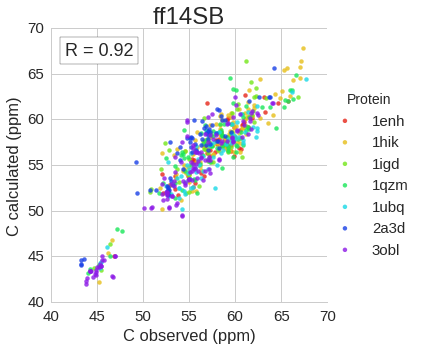

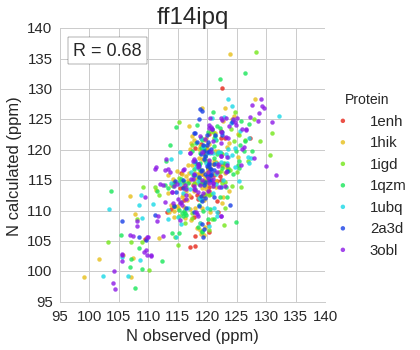

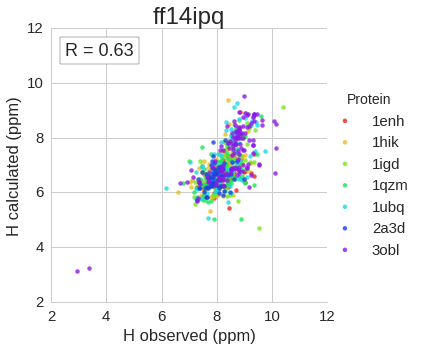

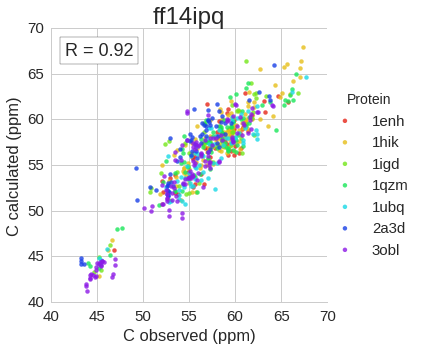

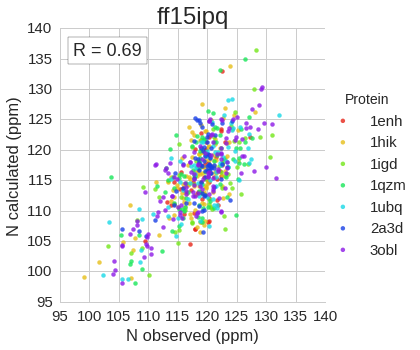

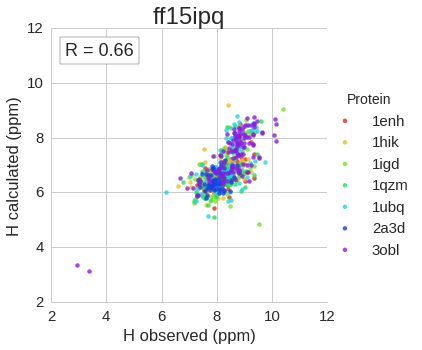

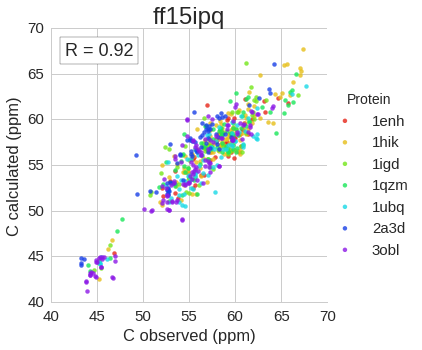

In [210]:
ff = 'ff15ipq'
atom = 'C'
for ff in fforder:
    for atom in ['N','H','C']:
        plt.figure(figsize=(8,8))
        dat = allv[allv.ff==ff].sort_values(by='prot')
        r = sns.lmplot('%so'%atom, atom, data=dat, hue='prot', fit_reg=False,scatter=True,aspect=1)
        if atom == 'H':
            plt.xlim(2,12)
            plt.ylim(2,12)
        elif atom == 'C':
            plt.ylim(40,70)
            plt.xlim(40,70)
        elif atom =='N':
            plt.xlim(95,140)
            plt.ylim(95,140)

        plt.title(ff,fontsize=24)
        r._legend.set_title("Protein")
        r.set_xlabels("%s observed (ppm)"%atom)
        r.set_ylabels("%s calculated (ppm)"%atom)
        R = scipy.stats.pearsonr(dat[atom],dat['%so'%atom])[0]
        plt.text(0.05,.95,'R = %.2f'%R,horizontalalignment='left',
             verticalalignment='top',bbox={'facecolor':'white', 'pad':5},transform = plt.gca().transAxes)
        plt.savefig('%s_%s_corr.pdf'%(ff,atom),bbox_inches='tight')



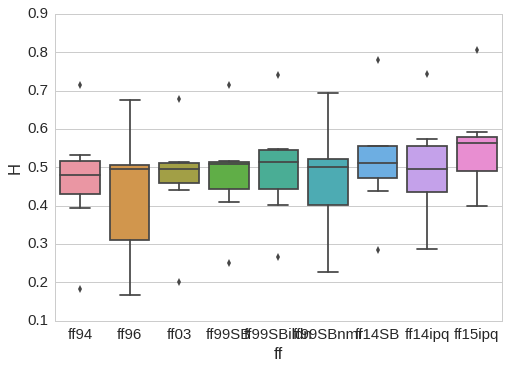

In [189]:
sns.boxplot(data=corrs,x='ff',y='H',order=fforder)

In [190]:
for x in ['N','C','H']:
    allv['%sabserr'%x] = abs(allv[x]-allv['%so'%x])
    allv['%ssqerr'%x] = (allv[x]-allv['%so'%x])**2
    allv['%sdiff'%x] = allv[x]-allv['%so'%x]

In [191]:
allmeans = allv.groupby(['ff','pattern']).mean().reset_index()

In [192]:
allmeans['Nerr'] = np.sqrt(allmeans.Nsqerr)
allmeans['Cerr'] = np.sqrt(allmeans.Csqerr)
allmeans['Herr'] = np.sqrt(allmeans.Hsqerr)

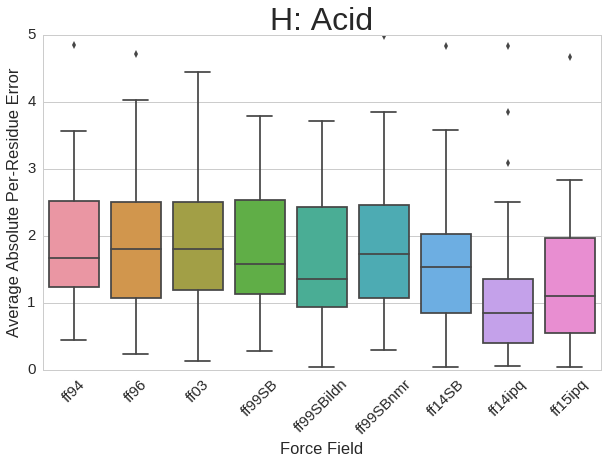

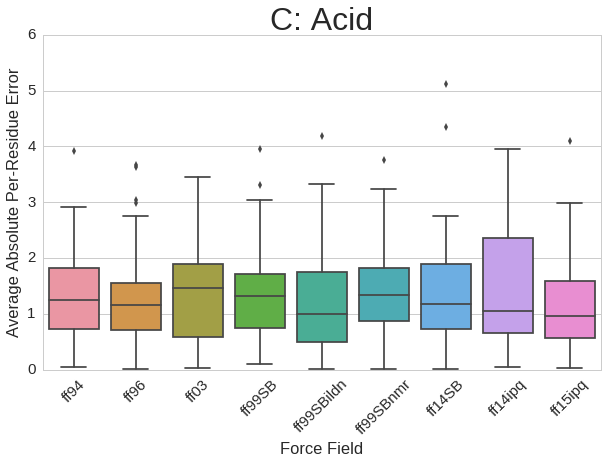

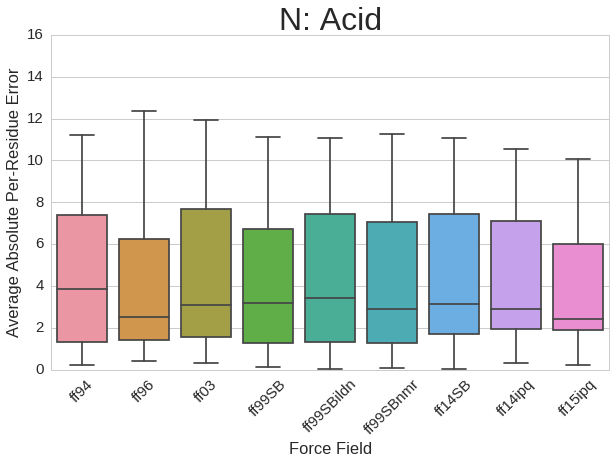

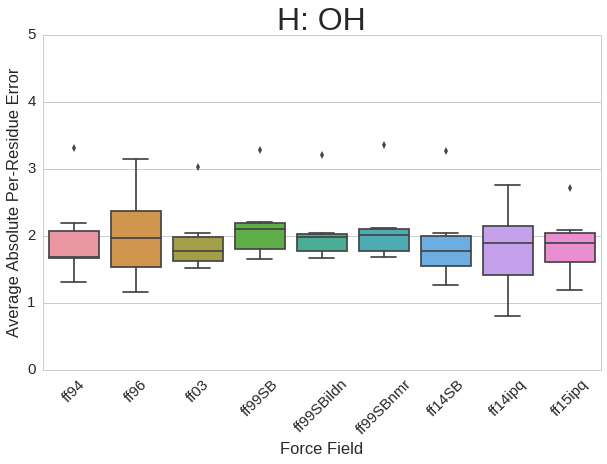

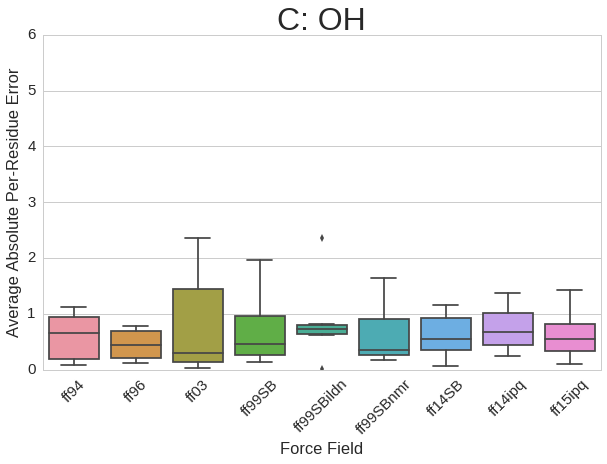

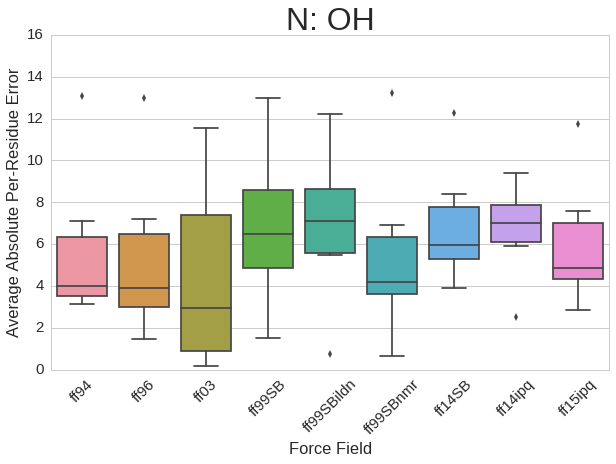

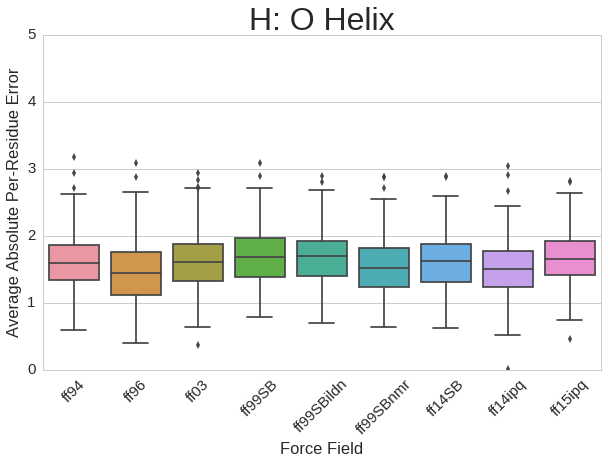

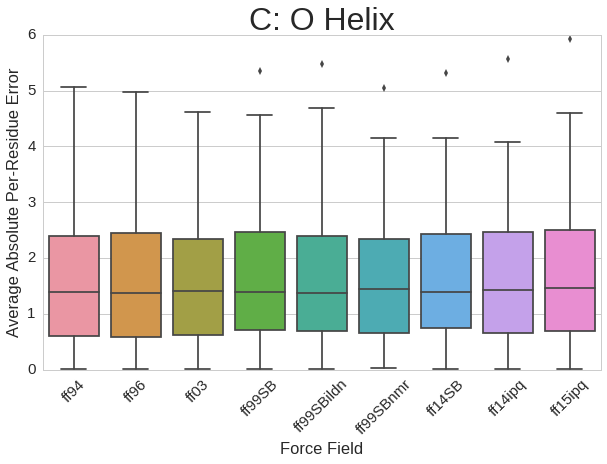

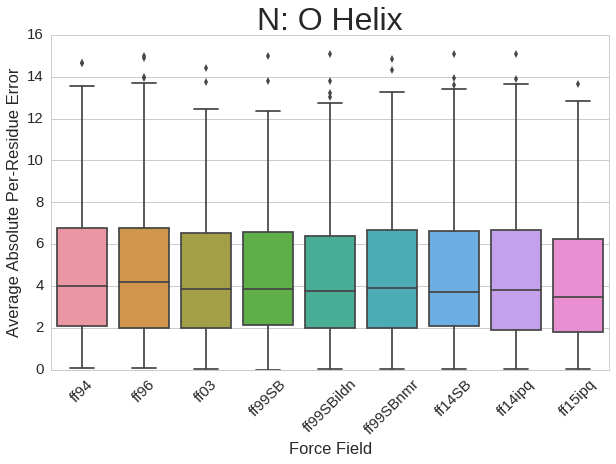

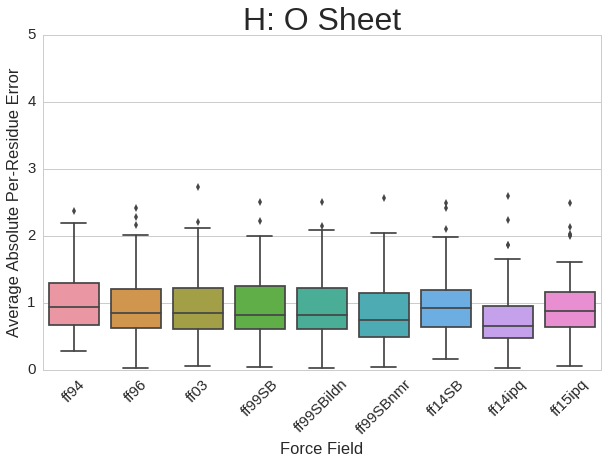

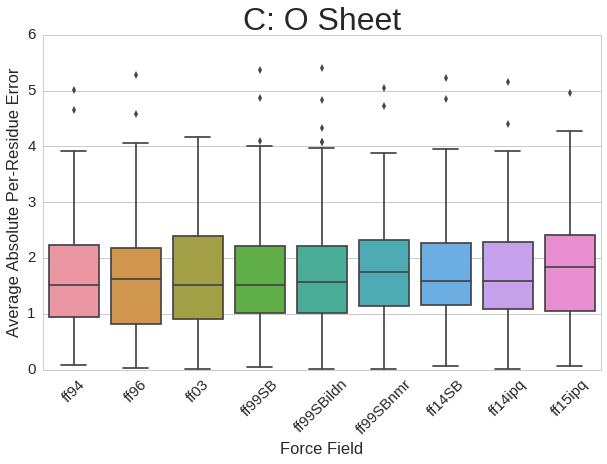

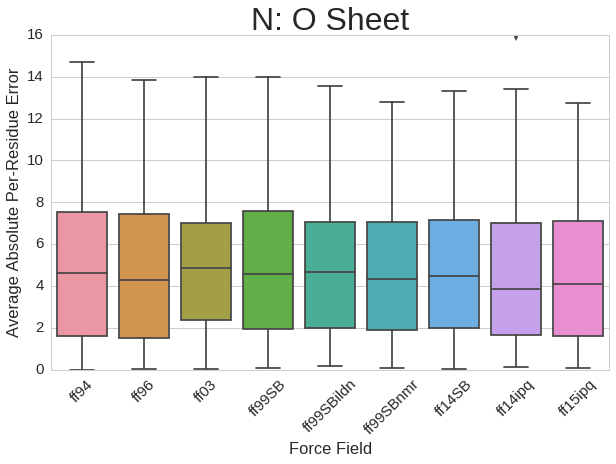

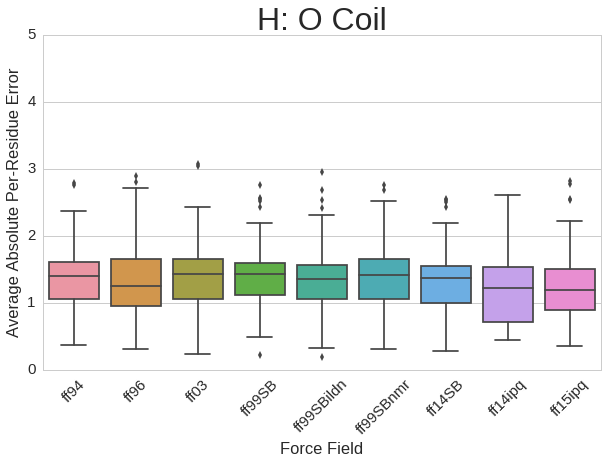

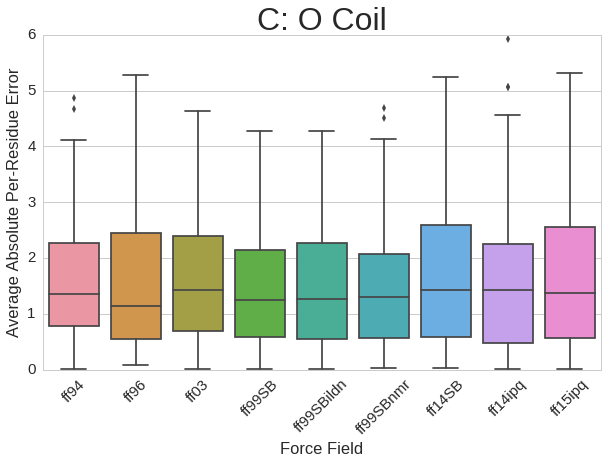

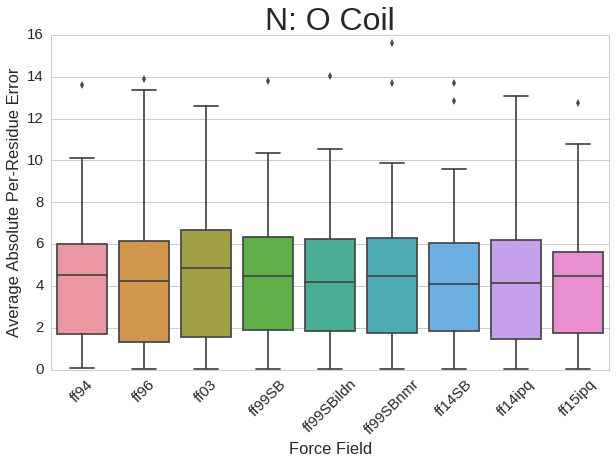

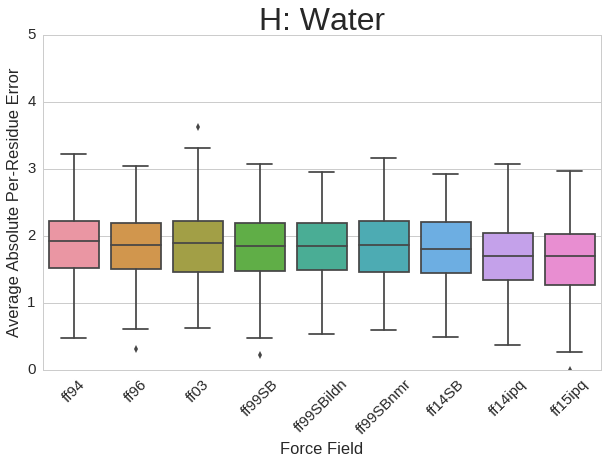

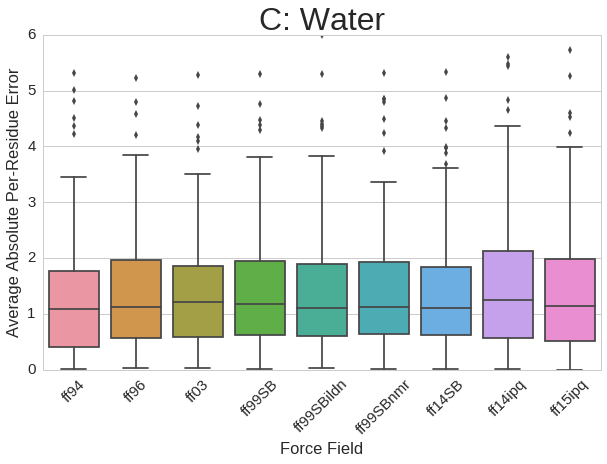

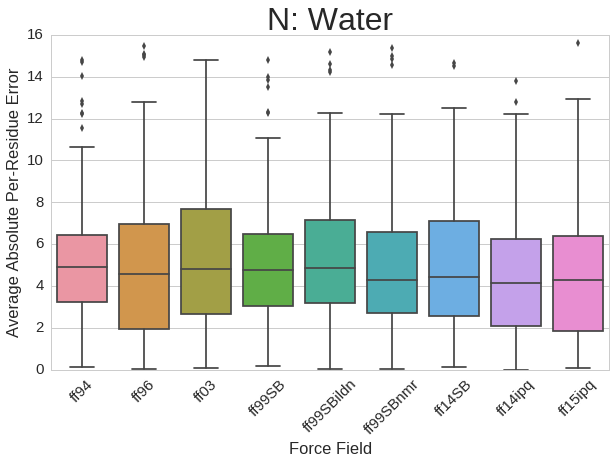

In [203]:
import matplotlib
matplotlib.rc('mathtext', fontset='stixsans') 

for pat in ['Acid','OH','O_Helix','O_Sheet','O_Coil','Water']:
    for atom in ['H','C','N']:
        plt.figure(figsize=(10,6))
        sns.boxplot(data=allv[allv.pattern==pat],x='ff',y='%sabserr'%atom,order=fforder)
        plt.ylabel("Average Absolute Per-Residue Error")
        plt.xlabel("Force Field")
        plt.xticks(rotation=45)
        if atom == 'H':
            plt.ylim(0,5)
        elif atom == 'N':
            plt.ylim(0,16)
        elif atom == 'C':
            plt.ylim(0,6)
        plt.title('%s: %s' % (atom,pat.replace('_',' ')),fontsize=32)
        plt.savefig('%s_%s_pat.pdf' %(pat,atom),bbox_inches='tight')


In [295]:
sb = allv[(allv.ff == 'ff14SB') & (allv.prot == '3obl')]
ipq = allv[(allv.ff == 'ff14ipq') & (allv.prot == '3obl')]

In [296]:
diff = sb.Habserr.values-ipq.Habserr.values 

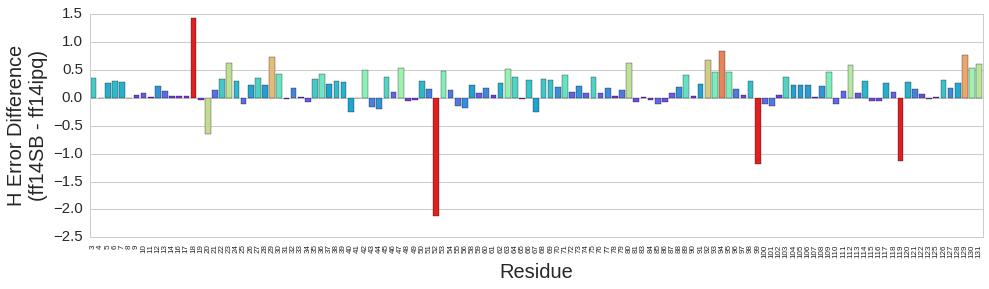

In [298]:
plt.figure(figsize=(16,4))
cmap = plt.get_cmap('rainbow')
sns.barplot(np.array(sb.rid.values,np.int),diff,palette=cmap(np.abs(diff)))
plt.xticks(rotation=90,fontsize=8)
plt.xlabel("Residue",fontsize=20)
plt.ylabel("H Error Difference\n(ff14SB - ff14ipq)",fontsize=20)
plt.savefig('3obl_diff.pdf',bbox_inches='tight')



In [302]:
!head analysis/PATTERNS

ff03 1enh 3 W
ff03 1enh 4 W
ff03 1enh 5 W
ff03 1enh 6 R
ff03 1enh 7 R
ff03 1enh 8 W
ff03 1enh 9 W
ff03 1enh 10 O:C
ff03 1enh 11 O:C
ff03 1enh 12 O:C


In [311]:
respatterns = collections.defaultdict(dict) #indexed prot-resid: set of all patterns
ffpatterns = collections.defaultdict(dict) #different dominant pattern for each ff
for line in open('analysis/PATTERNS'):
    (ff,prot,rid,pat) = line.split()
    rid = int(rid)
    if rid in ssdict[prot]:
        ss = ssdict[prot][rid]
        if 'O' in pat and 'C' in pat:
            if ss == 'H':
                pattern = 'O_Helix'
            elif ss == 'E':
                pattern = 'O_Sheet'
            elif ss == 'C' or ss == 'T':
                pattern = 'O_Coil'
            else:
                pattern = 'O_UNK'
        elif 'A' in pat:
            pattern = 'Acid'
        elif 'L' in pat:
            pattern = "OH"
        elif 'W' in pat:
            pattern = 'Water'
        elif 'R' in pat:
            pattern = "Ring"
        else:
            pattern = 'UNK'
        if prot not in ffpatterns[ff]:
            ffpatterns[ff][prot] = dict()
        ffpatterns[ff][prot][rid] = pattern
        if rid not in respatterns[prot]:
            respatterns[prot][rid] = set()
        respatterns[prot][rid].add(pattern)

In [313]:
patcnts = collections.defaultdict(int)
for prot in respatterns.keys():
    for rid in respatterns[prot].keys():
        patcnts[tuple(respatterns[prot][rid])] += 1

In [317]:
sorted(patcnts.items(),key=lambda (x,c): -c)

[(('O_Helix',), 204),
 (('O_Sheet',), 96),
 (('Water',), 56),
 (('O_Coil',), 39),
 (('Ring',), 21),
 (('Water', 'Acid'), 20),
 (('Water', 'UNK'), 12),
 (('Water', 'O_Coil'), 11),
 (('Water', 'UNK', 'Acid'), 11),
 (('Water', 'Ring'), 10),
 (('O_UNK',), 9),
 (('O_Coil', 'Ring'), 8),
 (('UNK',), 8),
 (('Acid',), 5),
 (('Water', 'OH'), 5),
 (('O_Coil', 'UNK'), 5),
 (('Water', 'Acid', 'OH'), 4),
 (('O_Helix', 'OH'), 4),
 (('UNK', 'O_Sheet'), 3),
 (('Water', 'O_Coil', 'UNK'), 3),
 (('Water', 'Ring', 'UNK'), 3),
 (('Water', 'UNK', 'Acid', 'OH'), 3),
 (('O_Helix', 'Acid'), 3),
 (('Water', 'UNK', 'OH'), 3),
 (('O_Coil', 'Acid'), 3),
 (('Water', 'O_UNK'), 2),
 (('Water', 'O_Coil', 'Acid'), 2),
 (('Water', 'Ring', 'OH'), 2),
 (('Water', 'Ring', 'Acid'), 2),
 (('O_Helix', 'UNK'), 2),
 (('Water', 'O_Helix'), 2),
 (('Acid', 'O_Sheet'), 2),
 (('O_Helix', 'UNK', 'Acid'), 2),
 (('Water', 'O_Coil', 'OH'), 2),
 (('O_Helix', 'Ring'), 2),
 (('Ring', 'UNK'), 1),
 (('O_Coil', 'Ring', 'UNK'), 1),
 (('OH',), 1

In [319]:
patsizecnts = collections.defaultdict(int)
for (x,c) in patcnts.items():
    patsizecnts[len(x)] += c

In [442]:
patsizecnts

defaultdict(int, {1: 439, 2: 97, 3: 40, 4: 6})

In [446]:
(patsizecnts[2]+patsizecnts[3]+patsizecnts[4])/float(np.sum(patsizecnts.values()))

0.24570446735395188

In [359]:
#change allv patterns to be ff specific - I'm sure there's a much much more efficient way to do this in pands
for ff in ffpatterns.keys():
    for prot in ffpatterns[ff].keys():
        for rid in ffpatterns[ff][prot].keys():
            allv.loc[allv[(allv.ff == ff) & (allv.prot == prot) & (allv.rid == rid)].index, 'pattern'] = ffpatterns[ff][prot][rid]
            allv.loc[allv[(allv.ff == ff) & (allv.prot == prot) & (allv.rid == rid)].index, 'patcnt'] = len(respatterns[prot][rid])

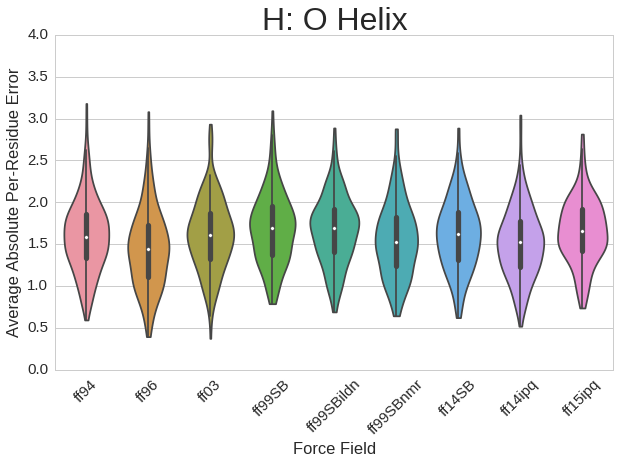

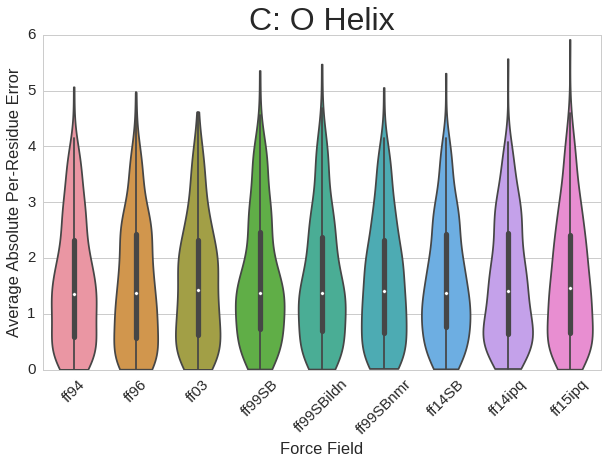

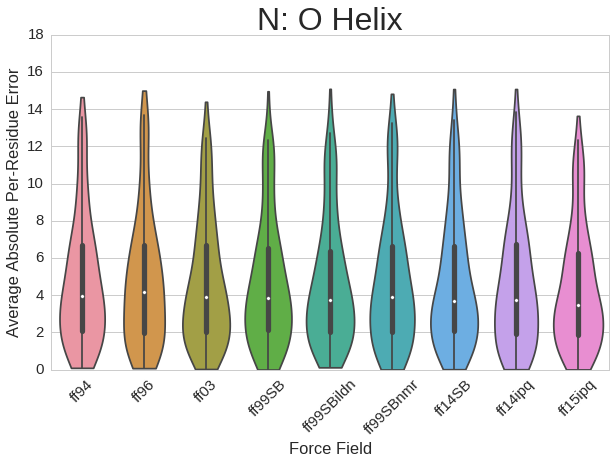

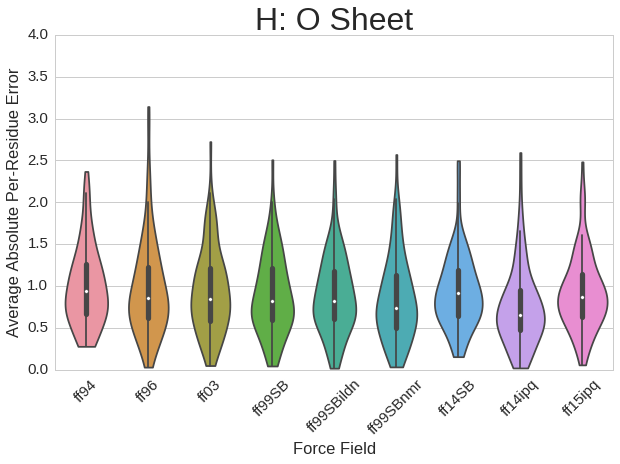

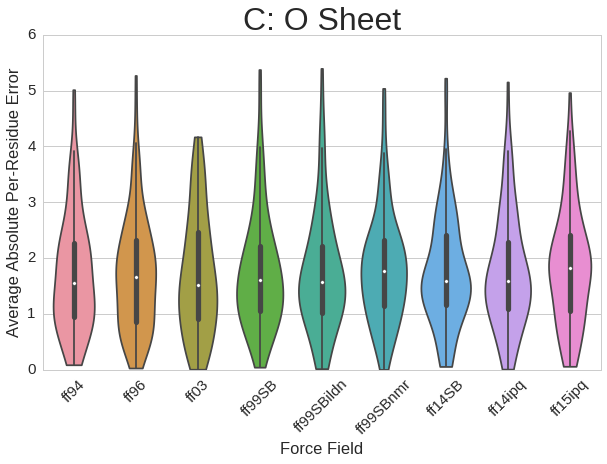

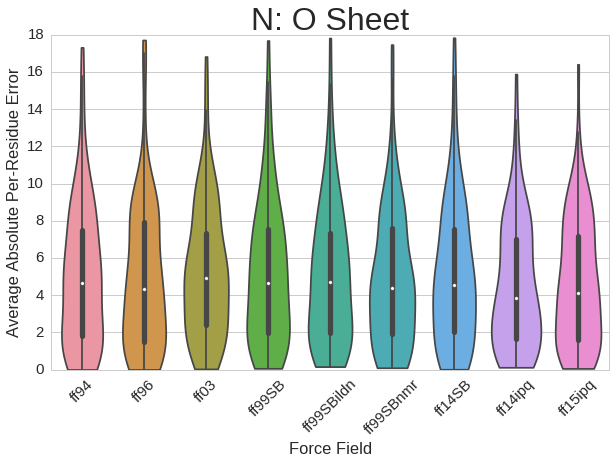

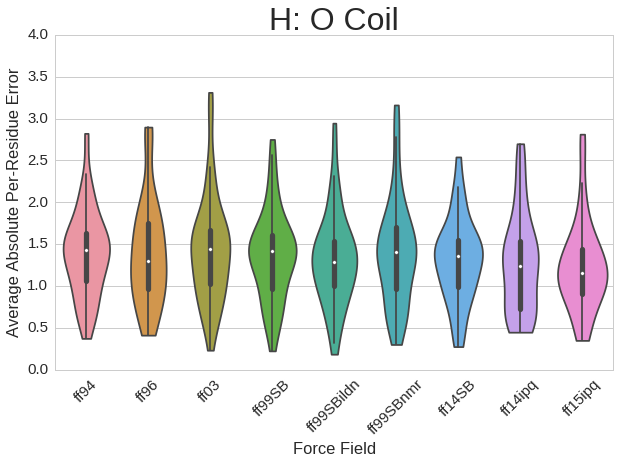

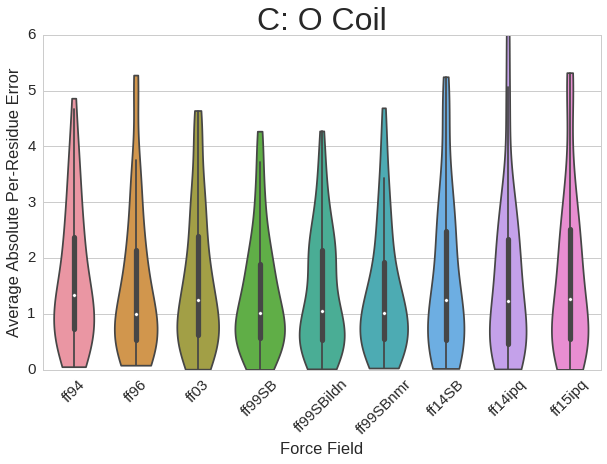

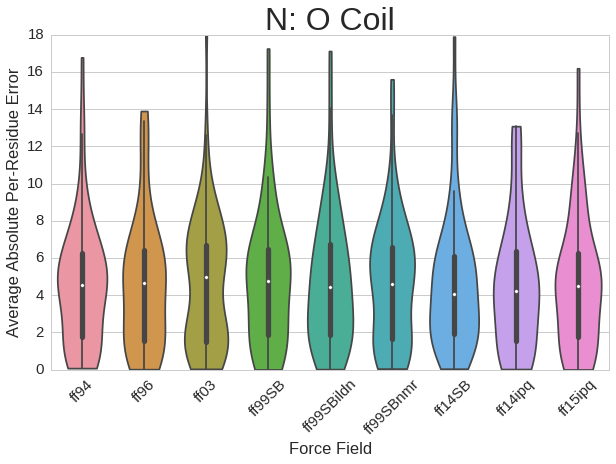

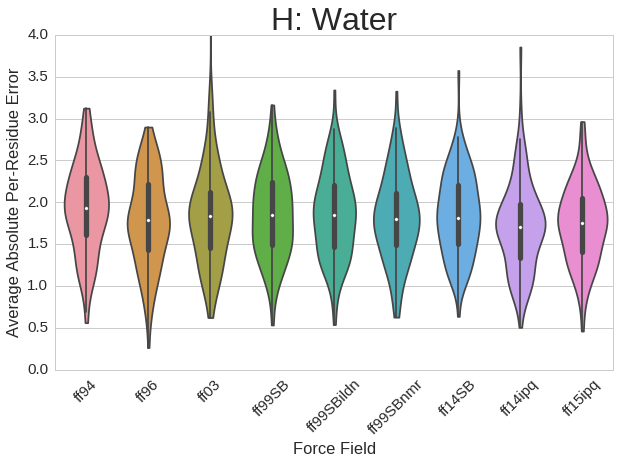

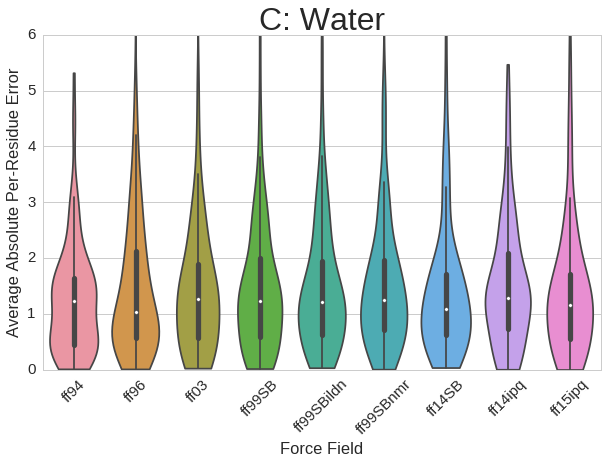

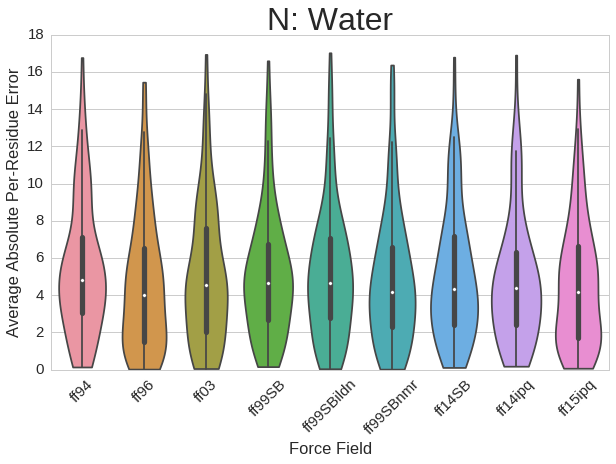

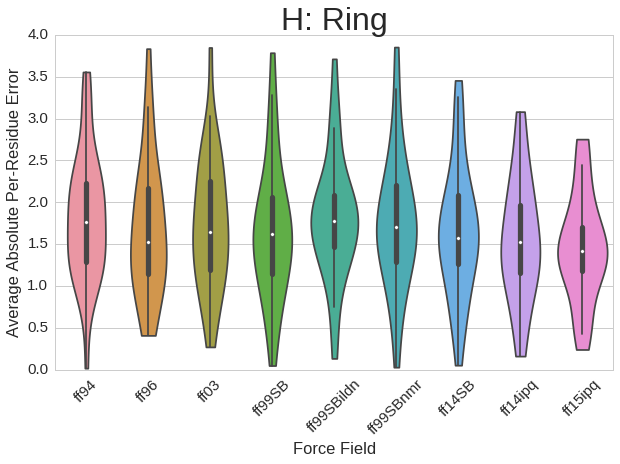

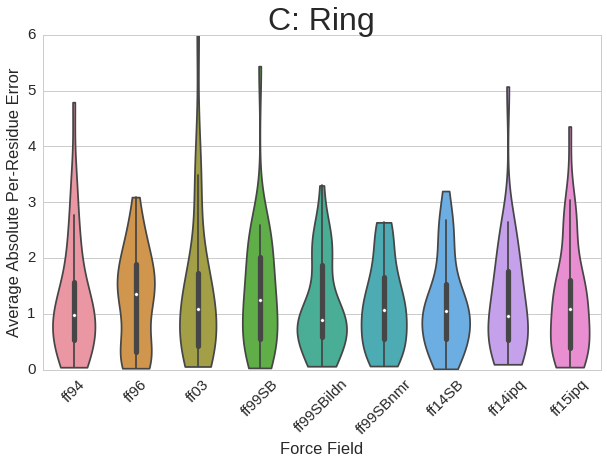

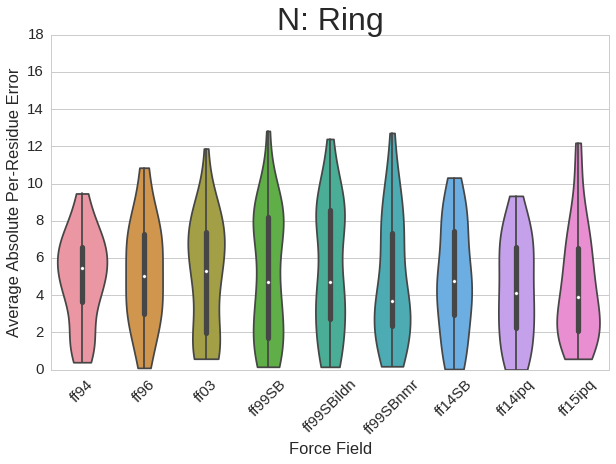

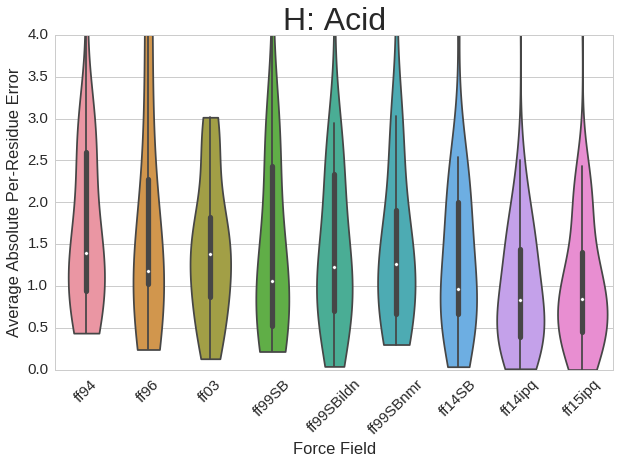

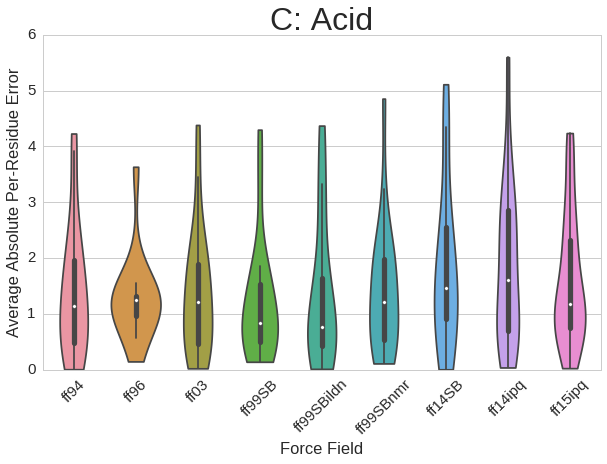

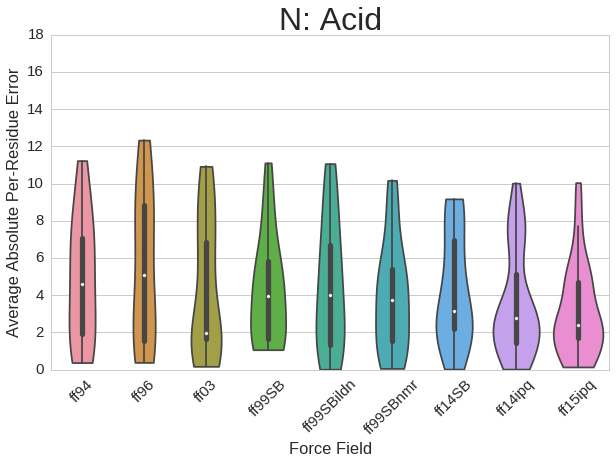

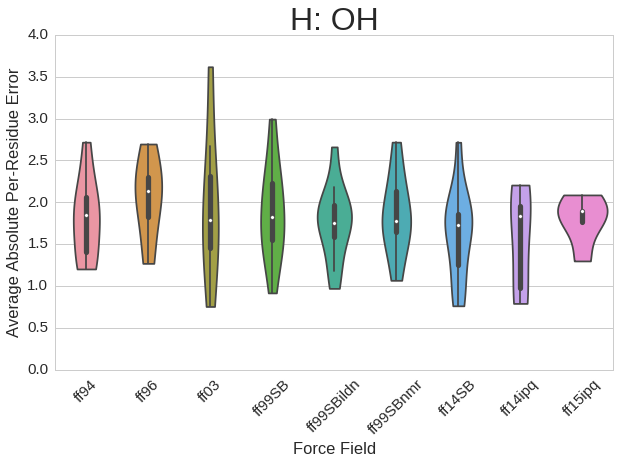

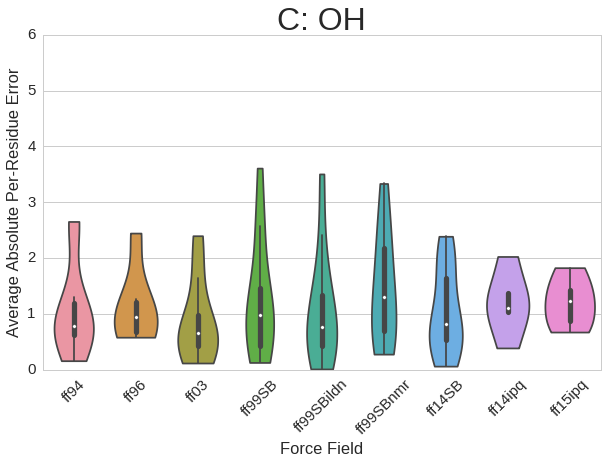

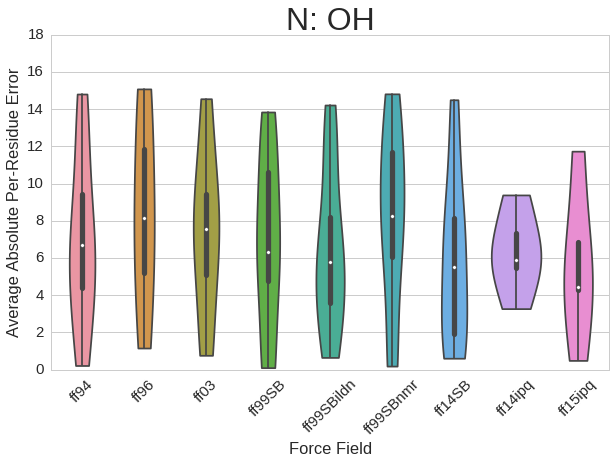

In [365]:
for pat in ['O_Helix','O_Sheet','O_Coil','Water','Ring','Acid','OH']:
    for atom in ['H','C','N']:
        plt.figure(figsize=(10,6))
        sns.violinplot(data=allv[(allv.pattern==pat)],x='ff',y='%sabserr'%atom,order=fforder,cut=0)
        plt.ylabel("Average Absolute Per-Residue Error")
        plt.xlabel("Force Field")
        plt.xticks(rotation=45)
        if atom == 'H':
            plt.ylim(0,4)
        elif atom == 'N':
            plt.ylim(0,18)
        elif atom == 'C':
            plt.ylim(0,6)
        plt.title('%s: %s' % (atom,pat.replace('_',' ')),fontsize=32)
        plt.savefig('%s_%s_ffpat.pdf' %(pat,atom),bbox_inches='tight')



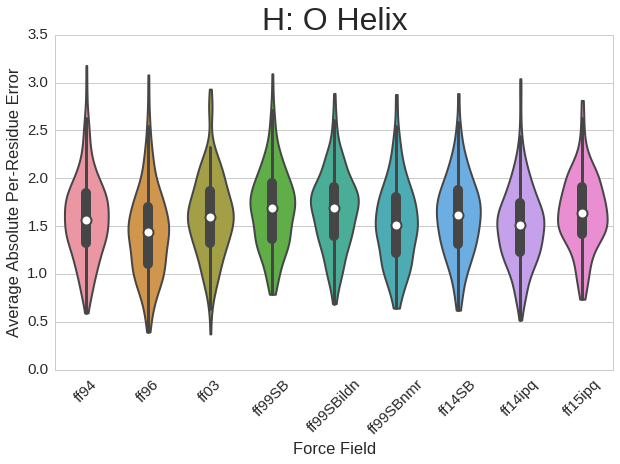

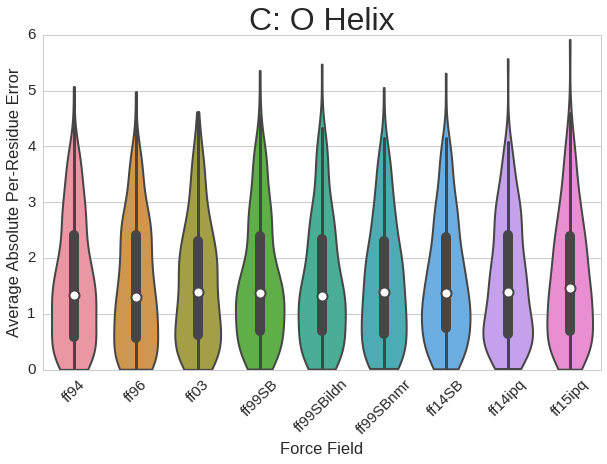

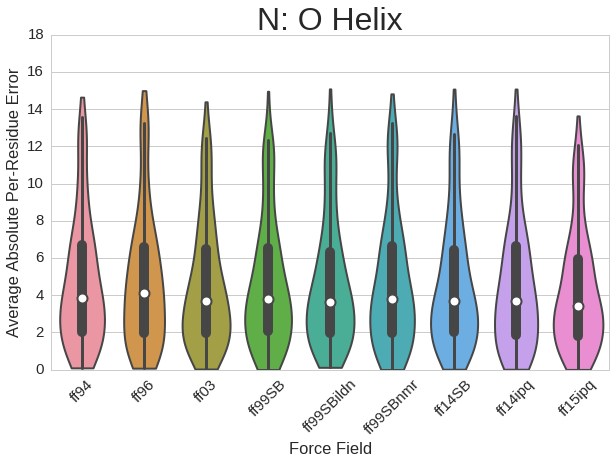

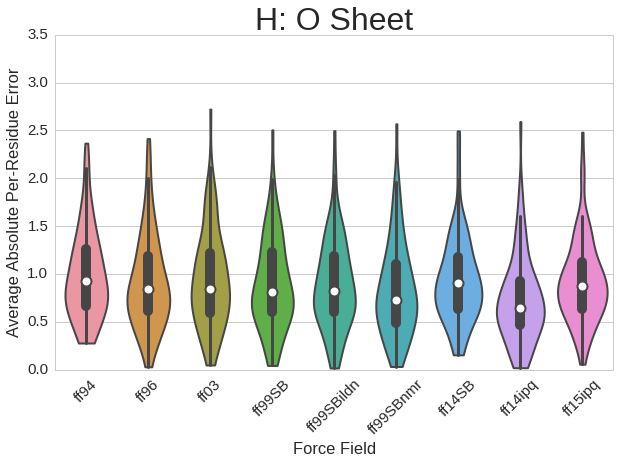

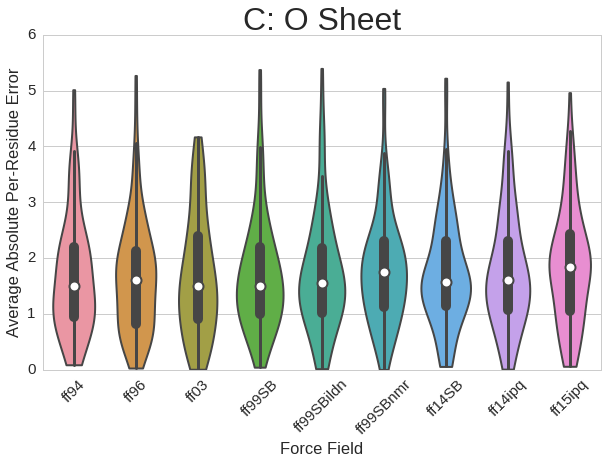

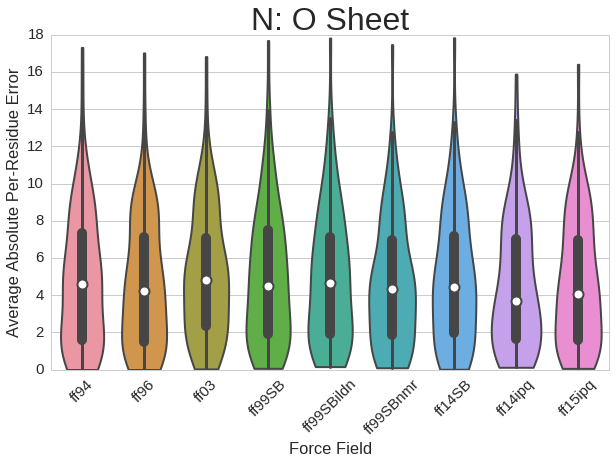

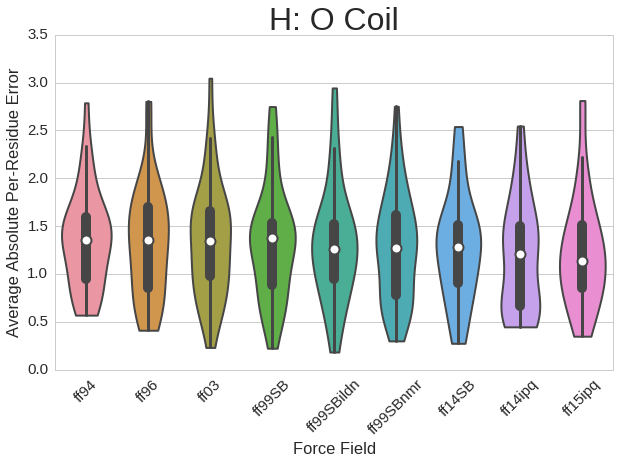

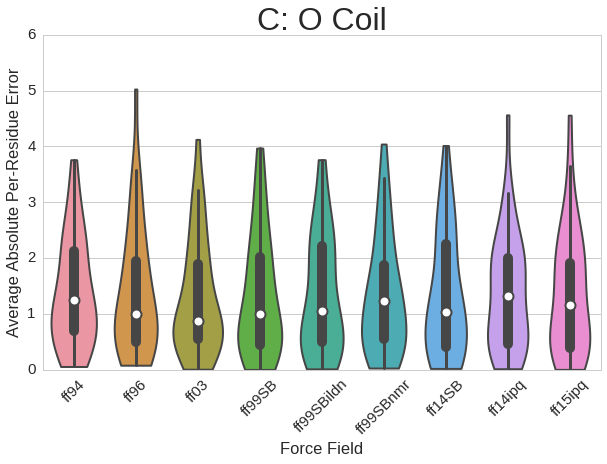

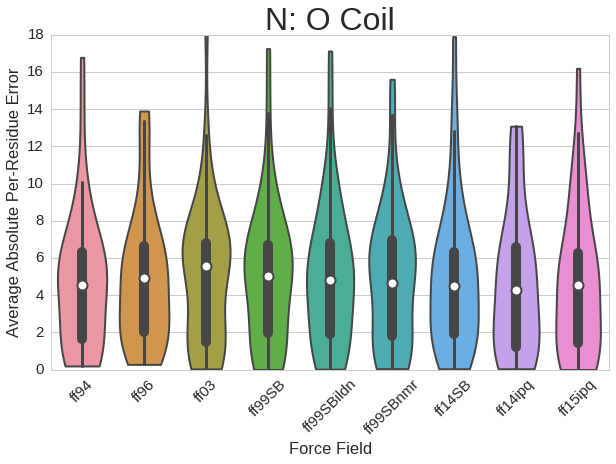

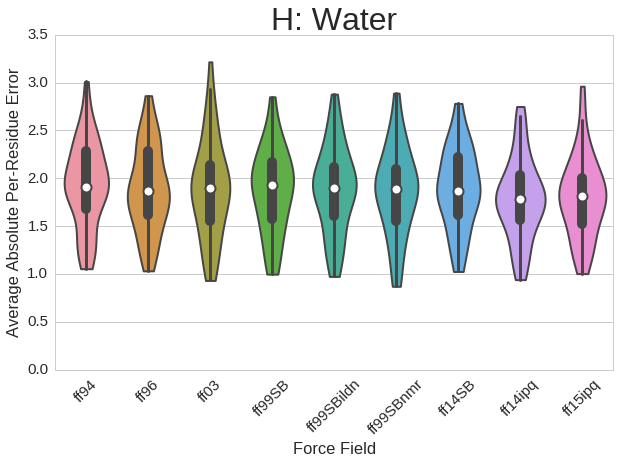

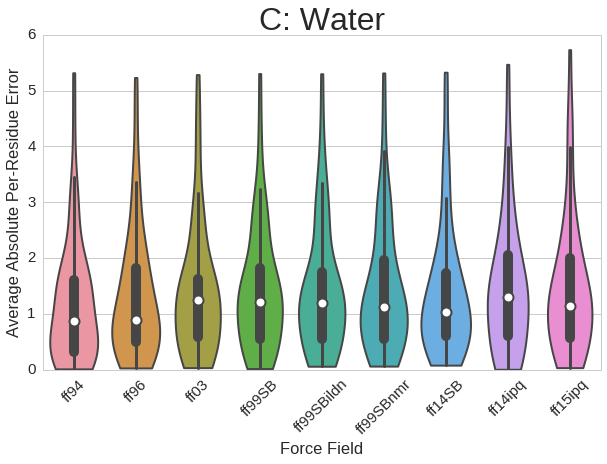

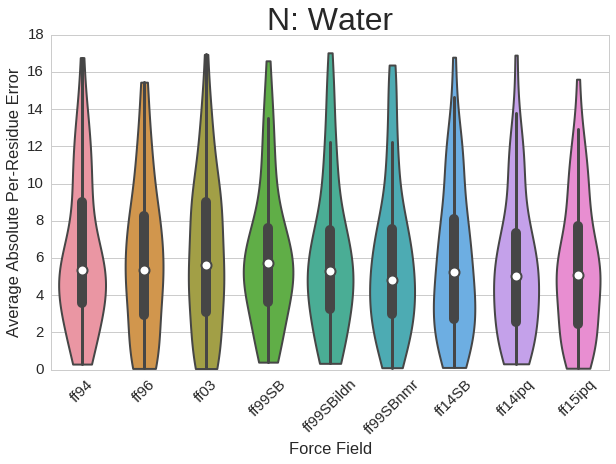

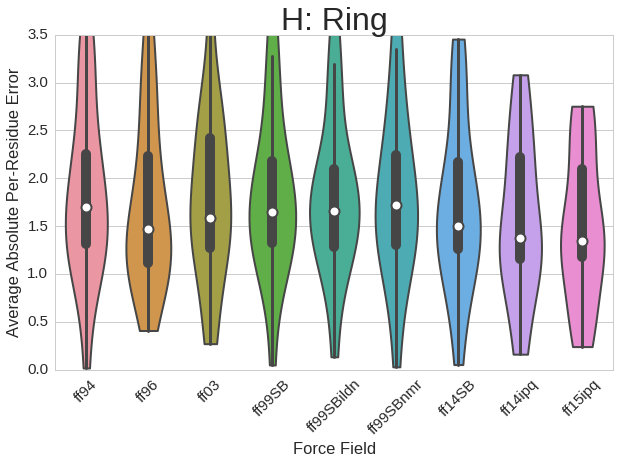

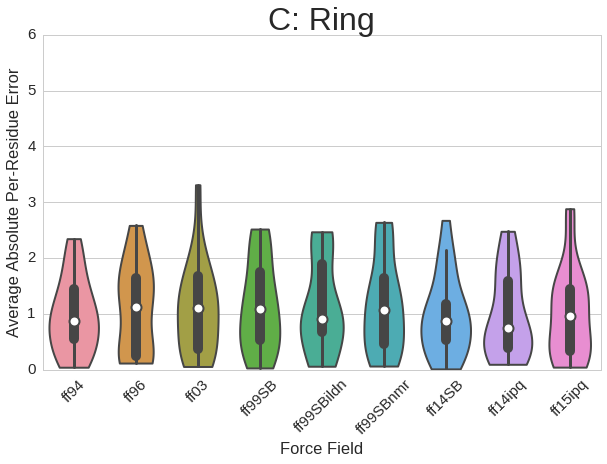

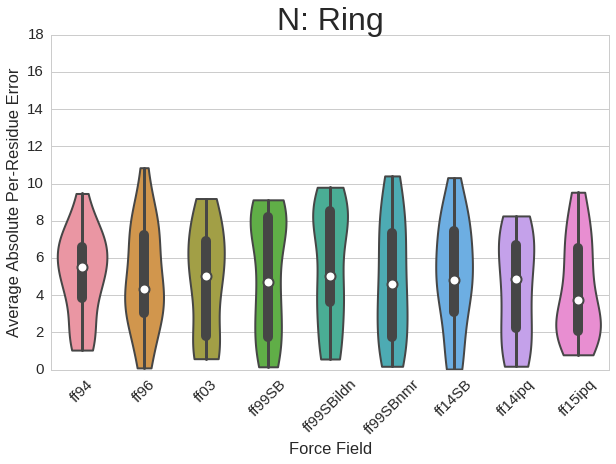

In [440]:
for pat in ['O_Helix','O_Sheet','O_Coil','Water','Ring']:
    for atom in ['H','C','N']:
        plt.figure(figsize=(10,6))
        ax = sns.violinplot(linewidth=5,data=allv[(allv.pattern==pat) & (allv.patcnt == 1)],x='ff',y='%sabserr'%atom,order=fforder,cut=0)
        plt.ylabel("Average Absolute Per-Residue Error")
        plt.xlabel("Force Field")
        plt.xticks(rotation=45)
        for l in ax.lines:
            if l.get_linewidth() == 5:
                l.set_linewidth(3)
            elif l.get_linewidth() == 15:
                l.set_linewidth(10)
        for c in ax.collections:
            c.set_linewidth(2)
        if atom == 'H':
            plt.ylim(0,3.5)
        elif atom == 'N':
            plt.ylim(0,18)
        elif atom == 'C':
            plt.ylim(0,6)
        plt.title('%s: %s' % (atom,pat.replace('_',' ')),fontsize=32)
        plt.savefig('%s_%s_upat.pdf' %(pat,atom),bbox_inches='tight')




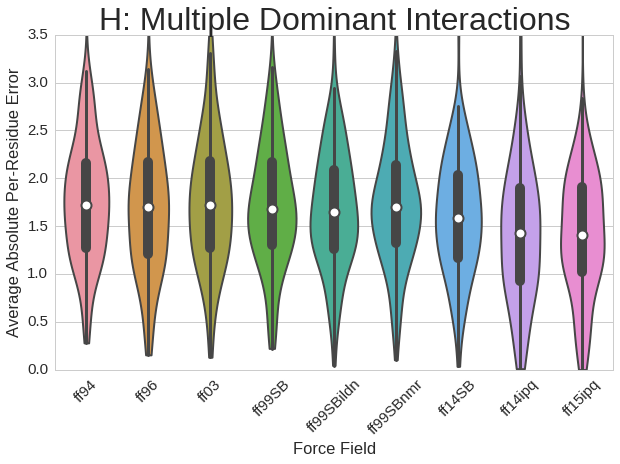

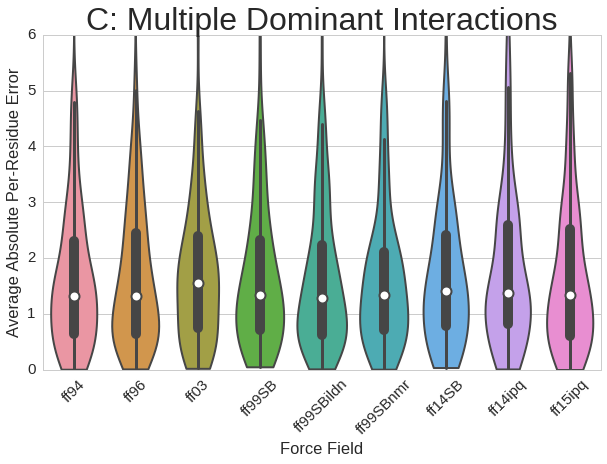

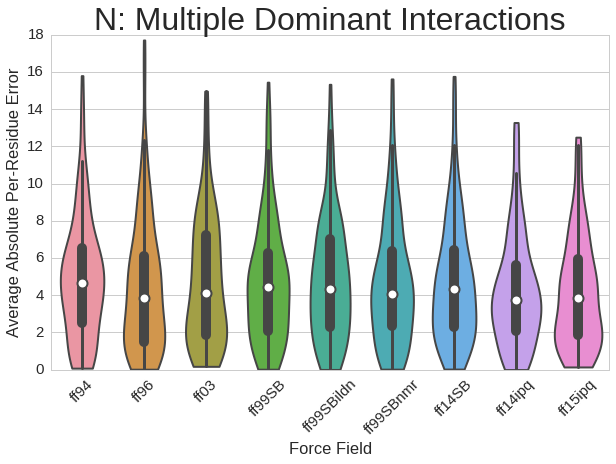

In [445]:
for atom in ['H','C','N']:
    plt.figure(figsize=(10,6))
    ax = sns.violinplot(data=allv[(allv.patcnt >= 2)],x='ff',y='%sabserr'%atom,order=fforder,cut=0,linewidth=5)
    for l in ax.lines:
        if l.get_linewidth() == 5:
            l.set_linewidth(3)
        else:
            l.set_linewidth(10)
    for c in ax.collections:
        c.set_linewidth(2)
                
    plt.ylabel("Average Absolute Per-Residue Error")
    plt.xlabel("Force Field")
    plt.xticks(rotation=45)
    if atom == 'H':
        plt.ylim(0,3.5)
    elif atom == 'N':
        plt.ylim(0,18)
    elif atom == 'C':
        plt.ylim(0,6)
    plt.title('%s: Multiple Dominant Interactions' % atom,fontsize=32)
    plt.savefig('%s_multipat.pdf' %(atom),bbox_inches='tight')



In [412]:
for x in ax.__dict__.iteritems():
    if type(x[1]) == type([]):
        print x[0],type(x[1]),len(x[1])

tables <type 'list'> 0
patches <type 'list'> 0
collections <type 'list'> 18
images <type 'list'> 0
texts <type 'list'> 0
artists <type 'list'> 0
containers <type 'list'> 0
_path_effects <type 'list'> 0
lines <type 'list'> 18


In [427]:
c.get_children()

[]

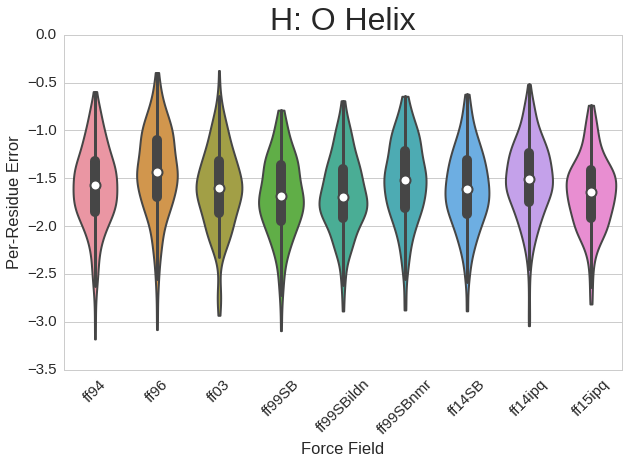

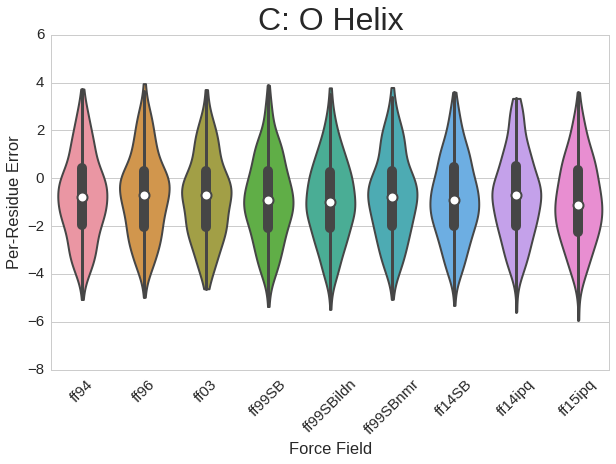

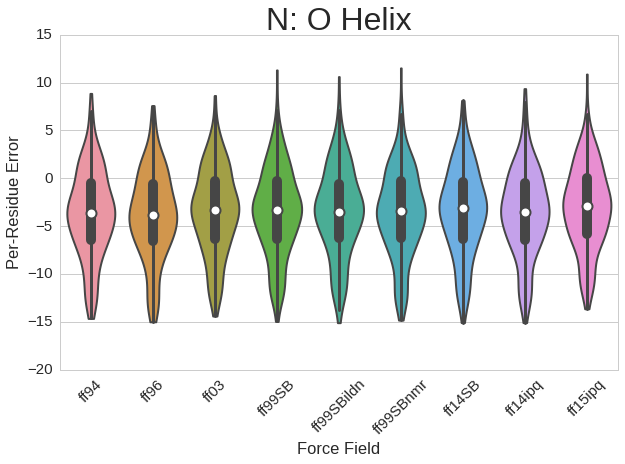

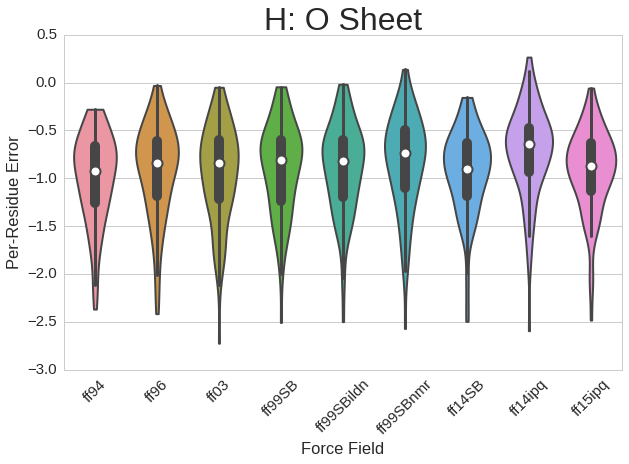

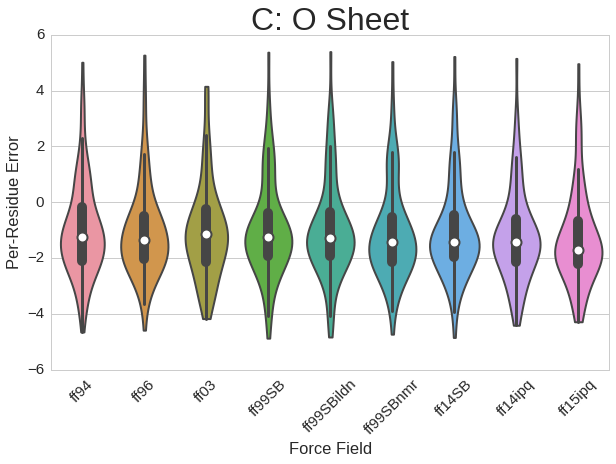

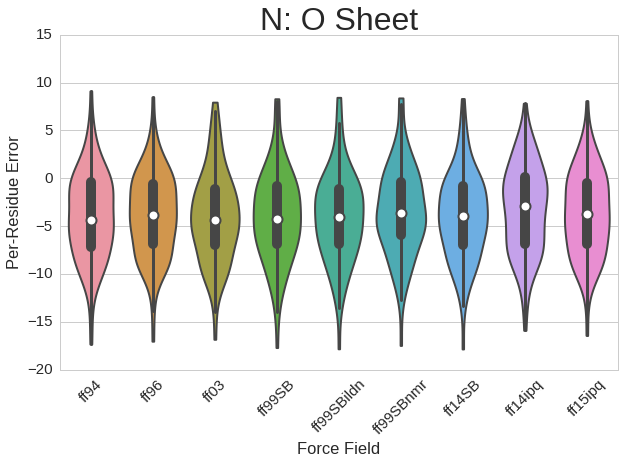

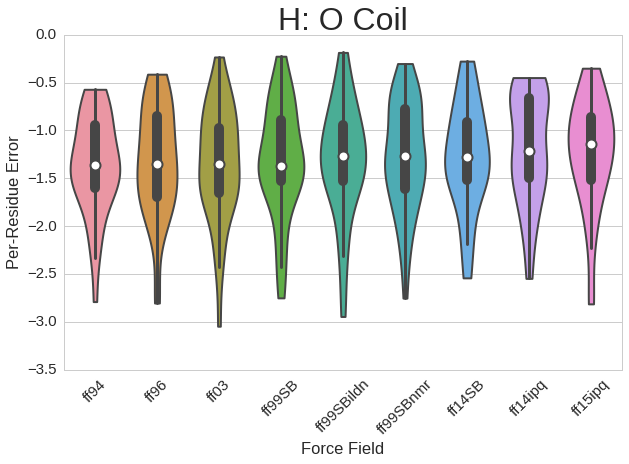

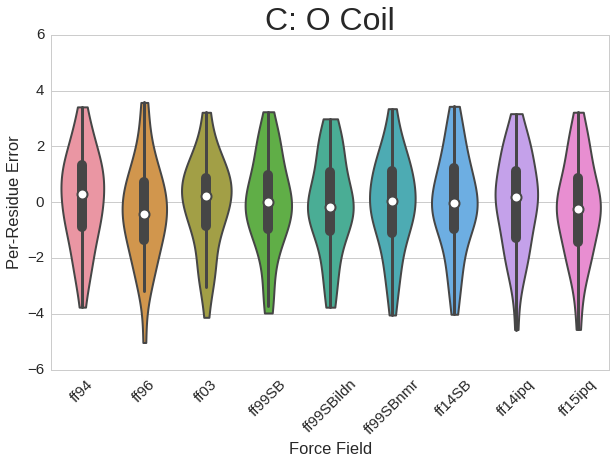

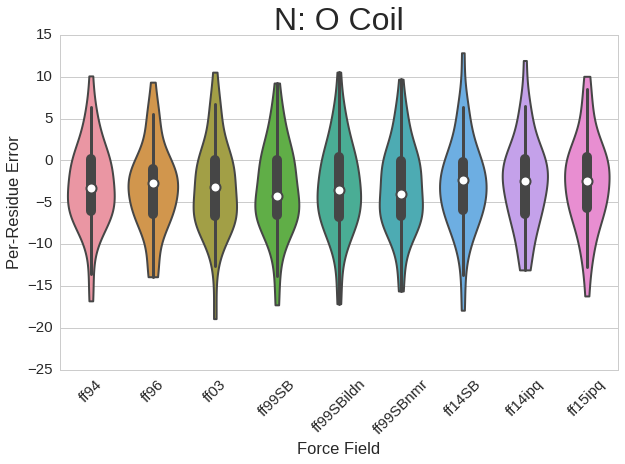

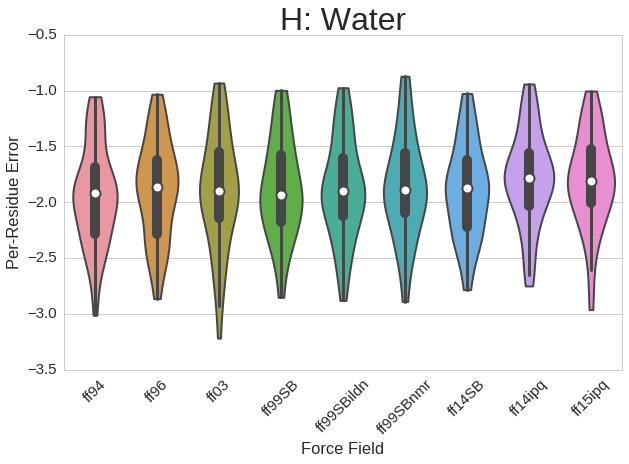

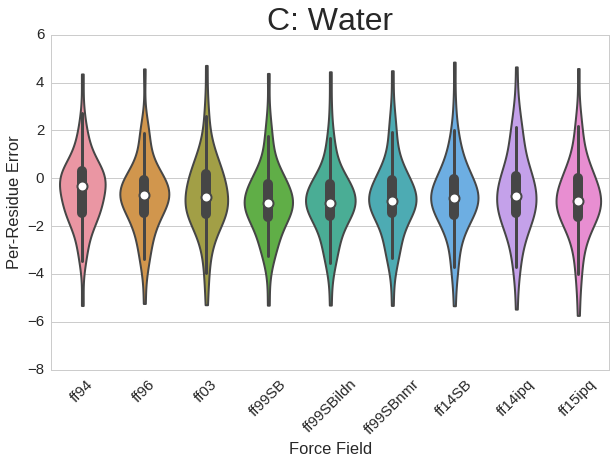

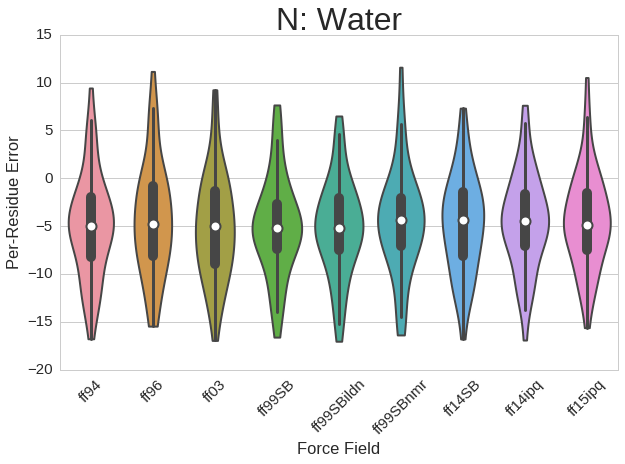

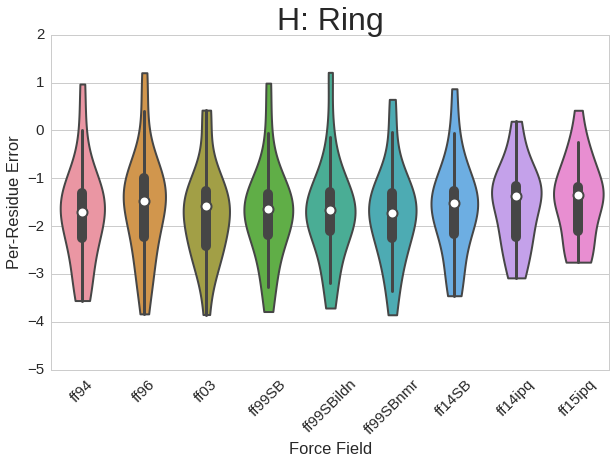

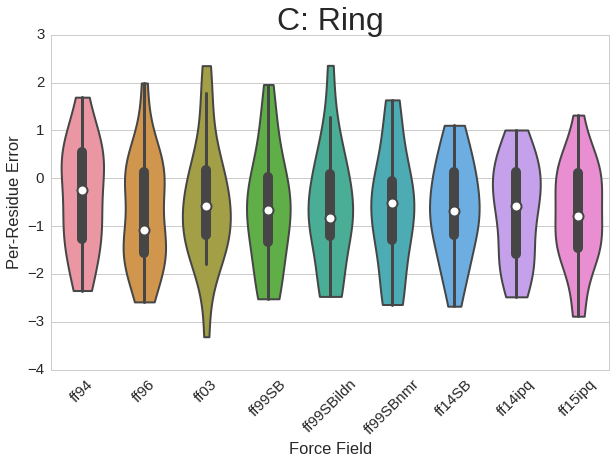

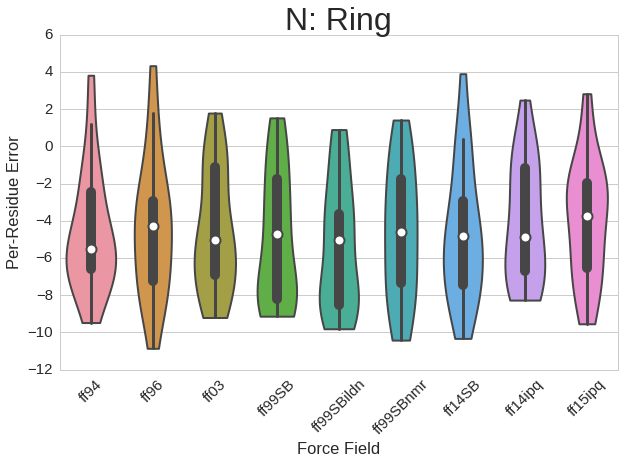

In [449]:
for pat in ['O_Helix','O_Sheet','O_Coil','Water','Ring']:
    for atom in ['H','C','N']:
        plt.figure(figsize=(10,6))
        ax = sns.violinplot(linewidth=5,data=allv[(allv.pattern==pat) & (allv.patcnt == 1)],x='ff',y='%sdiff'%atom,order=fforder,cut=0)
        plt.ylabel("Per-Residue Error")
        plt.xlabel("Force Field")
        plt.xticks(rotation=45)
        for l in ax.lines:
            if l.get_linewidth() == 5:
                l.set_linewidth(3)
            elif l.get_linewidth() == 15:
                l.set_linewidth(10)
        for c in ax.collections:
            c.set_linewidth(2)
        if True:
            pass
        elif atom == 'H':
            plt.ylim(0,3.5)
        elif atom == 'N':
            plt.ylim(0,18)
        elif atom == 'C':
            plt.ylim(0,6)
        plt.title('%s: %s' % (atom,pat.replace('_',' ')),fontsize=32)
        plt.savefig('%s_%s_upatdiff.pdf' %(pat,atom),bbox_inches='tight')




In [448]:
allv.columns

Index([u'ff', u'prot', u'rid', u'pattern', u'N', u'H', u'C', u'No', u'Ho',
       u'Co', u'Nabserr', u'Nsqerr', u'Ndiff', u'Cabserr', u'Csqerr', u'Cdiff',
       u'Habserr', u'Hsqerr', u'Hdiff', u'patcnt'],
      dtype='object')